# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')
df.head()

tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0              0             0                     0              0  
1              0             0                     0              0  
2              0             0                     0              0  
3              0             0                     0              0  
4              0             0                     0              0

In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# df.drop('in_btc', axis=1, inplace=True)
# df.drop('out_btc', axis=1, inplace=True)
# df.drop('total_btc', axis=1, inplace=True)
# df.drop('mean_in_btc', axis=1, inplace=True)
# df.drop('mean_out_btc', axis=1, inplace=True)


df.describe()

indegree     outdegree        in_btc       out_btc     total_btc  \
count  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07   
mean   2.148699e+00  2.148699e+00  5.484150e+01  5.484150e+01  1.096830e+02   
std    7.421447e+00  4.512048e+00  1.303303e+03  1.301473e+03  2.602527e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  1.000000e-01  9.950000e-02  2.058720e-01   
50%    1.000000e+00  2.000000e+00  9.325000e-01  9.590000e-01  1.964759e+00   
75%    2.000000e+00  2.000000e+00  8.591912e+00  9.063657e+00  1.840000e+01   
max    1.932000e+03  1.322000e+03  5.500000e+05  5.000207e+05  1.050000e+06   

        mean_in_btc  mean_out_btc  out_and_tx_malicious  
count  3.024813e+07  3.024813e+07          3.024813e+07  
mean   4.923980e+01  2.877087e+01          3.570468e-06  
std    9.729210e+02  7.125567e+02          1.889565e-03  
min    0.000000e+00  0.000000e+00          0.000000e+00  
25%    6.400000e-02  5.025776e-02          0.000000e+00  
50%    5.350261e-01  4.900000e-01          0.000000e+00  
75%    5.614287e+00  4.519481e+00          0.000000e+00  
max    4.992596e+05  5.000000e+05          1.000000e+00

In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [7]:
del df #free memory
gc.collect()

14

# Split

In [8]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [9]:
pd.value_counts(original_ytrain)

0    24198425
1          82
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

In [11]:
del scaled_df #free memory
gc.collect()

17

# Get Training Sample

In [12]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Get Test Sample

In [13]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Oversample Training Data

In [14]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

# Evaluation Metrics

In [15]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

# Save Model

In [18]:
model_path = './Models/PCA/'

def save_model(model, path):
    pickle.dump(model, open(path, 'wb'))

# Fit Model

In [19]:
from pyod.models.pca import PCA

iterations = 20
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
oversampling_fraction = 0.240
outliers_fraction = oversampling_fraction

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))


# best: {'n_components': 2.2476779439698413, 'outliers_fraction': 0.24510153421902092, 'tol': 0.17196077443292979}
# best: {'n_components': 2.8678593597562414, 'outliers_fraction': 0.2404968380546784, 'tol': 0.4493592072373634}


def fit_model(X_train):
    clf = PCA(n_components=3, 
              n_selected_components=1, 
              contamination=outliers_fraction, 
              copy=True, 
              whiten=False, 
              svd_solver='auto', 
              tol=0.5, 
              iterated_power='auto', 
              random_state=random_state, 
              weighted=True, 
              standardization=False)
    
    clf.fit(X_train)
    return clf

Training Parameters:

Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.24
Outliers Fraction: 0.24


# Iterative Modeling

In [20]:
training_evaluations = {}
test_evaluations = {}
model = {}

for i in range(0, iterations):
    sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
    print("Iteration "+ str(i+1)+ " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(X_train)
    end = time.time()
    save_model(clf, model_path+'i='+str(i+1)+'.h5')
    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    training_time = round(end - start, 4)
    model[i+1] = clf
    training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)
    
    print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    y_test_pred = clf.predict(original_Xtest)
    y_test_scores = clf.decision_function(original_Xtest)
    test_end = time.time()
    testing_time = round(test_end - test_start, 4)
    test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

    print("Iteration: (" + str((i+1)) + "/" + str(iterations) + ")    Training Time: "+str(training_time)+" seconds     Testing Time: "+ str(testing_time)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration 1 Trained
Iteration: (1/20)    Training Time: 6.6694 seconds     Testing Time: 1.1839 seconds
Iteration 2 in progress...
Iteration 2 Trained
Iteration: (2/20)    Training Time: 6.0793 seconds     Testing Time: 0.8565 seconds
Iteration 3 in progress...
Iteration 3 Trained
Iteration: (3/20)    Training Time: 5.3711 seconds     Testing Time: 0.8253 seconds
Iteration 4 in progress...
Iteration 4 Trained
Iteration: (4/20)    Training Time: 5.8239 seconds     Testing Time: 0.8573 seconds
Iteration 5 in progress...
Iteration 5 Trained
Iteration: (5/20)    Training Time: 5.7261 seconds     Testing Time: 0.883 seconds
Iteration 6 in progress...
Iteration 6 Trained
Iteration: (6/20)    Training Time: 5.4997 seconds     Testing Time: 0.9632 seconds
Iteration 7 in progress...
Iteration 7 Trained
Iteration: (7/20)    Training Time: 5.1902 seconds     Testing Time: 0.8656 seconds
Iteration 8 in progress...
Iteration 8 Trained
Iteration: (8/20)    Training Time: 6

# Tabular Evaluation

In [26]:
training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(training_evaluations.keys()):
    training_eval_df = training_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : training_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : training_evaluations[it]['macro_precision'],
                             'Macro-Recall' : training_evaluations[it]['macro_recall'],
                             'Macro-F1' : training_evaluations[it]['macro_f1'],
                             'Macro-ROC' : training_evaluations[it]['macro_roc'],
                             'Precision' : training_evaluations[it]['precision'],
                             'Recall' : training_evaluations[it]['recall'],
                             'F1' : training_evaluations[it]['f1'],
                             'ROC' : training_evaluations[it]['roc'],
                             'Time' : training_evaluations[it]['time']                                              
                            }, ignore_index=True)
    
for it in list(test_evaluations.keys()):
    test_eval_df = test_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : test_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : test_evaluations[it]['macro_precision'],
                             'Macro-Recall' : test_evaluations[it]['macro_recall'],
                             'Macro-F1' : test_evaluations[it]['macro_f1'],
                             'Macro-ROC' : test_evaluations[it]['macro_roc'],
                             'Precision' : test_evaluations[it]['precision'],
                             'Recall' : test_evaluations[it]['recall'],
                             'F1' : test_evaluations[it]['f1'],
                             'ROC' : test_evaluations[it]['roc'],
                             'Time' : test_evaluations[it]['time']                                              
                            }, ignore_index=True)

In [27]:
training_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
18        19  0.855803           0.814644         0.769254      0.814644   
4          5  0.855719           0.814511         0.769140      0.814511   
9         10  0.855663           0.814420         0.769063      0.814420   
16        17  0.855622           0.814354         0.769006      0.814354   
3          4  0.855602           0.814323         0.768979      0.814323   
6          7  0.855552           0.814243         0.768911      0.814243   
0          1  0.855533           0.814212         0.768884      0.814212   
14        15  0.855521           0.814193         0.768868      0.814193   
10        11  0.855434           0.814053         0.768748      0.814053   
7          8  0.855268           0.813787         0.768521      0.813787   
5          6  0.851816           0.808259         0.763790      0.808259   
13        14  0.851678           0.808037         0.763600      0.808037   
12        13  0.851660           0.808010         0.763577      0.808010   
17        18  0.851602           0.807904         0.763496      0.807904   
19        20  0.851484           0.807727         0.763335      0.807727   
15        16  0.851342           0.807499         0.763140      0.807499   
2          3  0.851282           0.807404         0.763059      0.807404   
1          2  0.851282           0.807403         0.763058      0.807403   
8          9  0.851241           0.807338         0.763002      0.807338   
11        12  0.851177           0.807236         0.762914      0.807236   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
18  0.787675   0.893438   0.602815  0.747491  0.667403  0.893438  5.5105  
4   0.787552   0.893100   0.602641  0.747276  0.667210  0.893100  5.7261  
9   0.787469   0.893047   0.602523  0.747130  0.667080  0.893047  5.5939  
16  0.787408   0.892859   0.602437  0.747023  0.666984  0.892859  5.2143  
3   0.787379   0.893145   0.602397  0.746973  0.666940  0.893145  5.8239  
6   0.787306   0.892894   0.602293  0.746844  0.666825  0.892894  5.1902  
0   0.787277   0.893143   0.602253  0.746794  0.666780  0.893143  6.6694  
14  0.787259   0.893068   0.602228  0.746763  0.666752  0.893068  5.4579  
10  0.787131   0.892791   0.602046  0.746537  0.666551  0.892791  5.5301  
7   0.786887   0.892802   0.601700  0.746109  0.666168  0.892802  6.4253  
5   0.781805   0.896883   0.594510  0.737193  0.658207  0.896883  5.4997  
13  0.781600   0.896849   0.594221  0.736835  0.657888  0.896849  5.3444  
12  0.781575   0.896700   0.594185  0.736790  0.657848  0.896700  5.6395  
17  0.781485   0.896612   0.594069  0.736607  0.657704  0.896612  5.4828  
19  0.781315   0.896566   0.593817  0.736333  0.657440  0.896566  5.5712  
15  0.781106   0.896338   0.593521  0.735967  0.657113  0.896338  5.7013  
2   0.781018   0.896527   0.593398  0.735814  0.656976  0.896527  5.3711  
1   0.781018   0.896273   0.593396  0.735812  0.656975  0.896273  6.0793  
8   0.780958   0.896373   0.593311  0.735707  0.656881  0.896373  5.4573  
11  0.780863   0.896528   0.593178  0.735541  0.656733  0.896528  5.3046

In [28]:
training_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
5          6  0.851816           0.808259         0.763790      0.808259   
13        14  0.851678           0.808037         0.763600      0.808037   
12        13  0.851660           0.808010         0.763577      0.808010   
17        18  0.851602           0.807904         0.763496      0.807904   
19        20  0.851484           0.807727         0.763335      0.807727   
11        12  0.851177           0.807236         0.762914      0.807236   
2          3  0.851282           0.807404         0.763059      0.807404   
8          9  0.851241           0.807338         0.763002      0.807338   
15        16  0.851342           0.807499         0.763140      0.807499   
1          2  0.851282           0.807403         0.763058      0.807403   
18        19  0.855803           0.814644         0.769254      0.814644   
3          4  0.855602           0.814323         0.768979      0.814323   
0          1  0.855533           0.814212         0.768884      0.814212   
4          5  0.855719           0.814511         0.769140      0.814511   
14        15  0.855521           0.814193         0.768868      0.814193   
9         10  0.855663           0.814420         0.769063      0.814420   
6          7  0.855552           0.814243         0.768911      0.814243   
16        17  0.855622           0.814354         0.769006      0.814354   
7          8  0.855268           0.813787         0.768521      0.813787   
10        11  0.855434           0.814053         0.768748      0.814053   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
5   0.781805   0.896883   0.594510  0.737193  0.658207  0.896883  5.4997  
13  0.781600   0.896849   0.594221  0.736835  0.657888  0.896849  5.3444  
12  0.781575   0.896700   0.594185  0.736790  0.657848  0.896700  5.6395  
17  0.781485   0.896612   0.594069  0.736607  0.657704  0.896612  5.4828  
19  0.781315   0.896566   0.593817  0.736333  0.657440  0.896566  5.5712  
11  0.780863   0.896528   0.593178  0.735541  0.656733  0.896528  5.3046  
2   0.781018   0.896527   0.593398  0.735814  0.656976  0.896527  5.3711  
8   0.780958   0.896373   0.593311  0.735707  0.656881  0.896373  5.4573  
15  0.781106   0.896338   0.593521  0.735967  0.657113  0.896338  5.7013  
1   0.781018   0.896273   0.593396  0.735812  0.656975  0.896273  6.0793  
18  0.787675   0.893438   0.602815  0.747491  0.667403  0.893438  5.5105  
3   0.787379   0.893145   0.602397  0.746973  0.666940  0.893145  5.8239  
0   0.787277   0.893143   0.602253  0.746794  0.666780  0.893143  6.6694  
4   0.787552   0.893100   0.602641  0.747276  0.667210  0.893100  5.7261  
14  0.787259   0.893068   0.602228  0.746763  0.666752  0.893068  5.4579  
9   0.787469   0.893047   0.602523  0.747130  0.667080  0.893047  5.5939  
6   0.787306   0.892894   0.602293  0.746844  0.666825  0.892894  5.1902  
16  0.787408   0.892859   0.602437  0.747023  0.666984  0.892859  5.2143  
7   0.786887   0.892802   0.601700  0.746109  0.666168  0.892802  6.4253  
10  0.787131   0.892791   0.602046  0.746537  0.666551  0.892791  5.5301

In [29]:
test_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
7          8  0.881970           0.883293         0.500016      0.883293   
0          1  0.881901           0.883258         0.500016      0.883258   
18        19  0.881852           0.883234         0.500016      0.883234   
9         10  0.881808           0.883212         0.500016      0.883212   
16        17  0.881808           0.883212         0.500016      0.883212   
3          4  0.881792           0.883204         0.500016      0.883204   
4          5  0.881757           0.883186         0.500016      0.883186   
10        11  0.881737           0.883176         0.500016      0.883176   
6          7  0.881679           0.883147         0.500016      0.883147   
14        15  0.881676           0.883146         0.500016      0.883146   
13        14  0.879623           0.862889         0.500015      0.862889   
12        13  0.879504           0.862829         0.500015      0.862829   
17        18  0.879397           0.862776         0.500015      0.862776   
5          6  0.879365           0.862759         0.500015      0.862759   
15        16  0.879336           0.862745         0.500015      0.862745   
8          9  0.879199           0.862676         0.500015      0.862676   
2          3  0.879174           0.862664         0.500015      0.862664   
1          2  0.879044           0.862599         0.500015      0.862599   
11        12  0.878905           0.862529         0.500015      0.862529   
19        20  0.878859           0.862506         0.500015      0.862506   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
7   0.468674   0.909814   0.000032  0.884615  0.000064  0.909814  0.9322  
0   0.468654   0.910061   0.000032  0.884615  0.000064  0.910061  1.1839  
18  0.468641   0.910491   0.000032  0.884615  0.000064  0.910491  0.8296  
9   0.468628   0.909745   0.000032  0.884615  0.000064  0.909745  0.9687  
16  0.468628   0.909967   0.000032  0.884615  0.000064  0.909967  0.8430  
3   0.468624   0.910157   0.000032  0.884615  0.000064  0.910157  0.8573  
4   0.468614   0.909917   0.000032  0.884615  0.000064  0.909917  0.8830  
10  0.468608   0.910082   0.000032  0.884615  0.000064  0.910082  0.9452  
6   0.468592   0.909964   0.000032  0.884615  0.000064  0.909964  0.8656  
14  0.468591   0.910166   0.000032  0.884615  0.000064  0.910166  0.8763  
13  0.468009   0.917315   0.000030  0.846154  0.000060  0.917315  0.8991  
12  0.467975   0.917360   0.000030  0.846154  0.000060  0.917360  0.8642  
17  0.467944   0.917235   0.000030  0.846154  0.000060  0.917235  0.8393  
5   0.467935   0.917357   0.000030  0.846154  0.000060  0.917357  0.9632  
15  0.467927   0.917220   0.000030  0.846154  0.000060  0.917220  1.1638  
8   0.467888   0.917200   0.000030  0.846154  0.000060  0.917200  0.9278  
2   0.467881   0.917208   0.000030  0.846154  0.000060  0.917208  0.8253  
1   0.467844   0.917239   0.000030  0.846154  0.000060  0.917239  0.8565  
11  0.467805   0.917177   0.000030  0.846154  0.000060  0.917177  0.8492  
19  0.467792   0.917190   0.000030  0.846154  0.000060  0.917190  0.8788

In [30]:
test_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
12        13  0.879504           0.862829         0.500015      0.862829   
5          6  0.879365           0.862759         0.500015      0.862759   
13        14  0.879623           0.862889         0.500015      0.862889   
1          2  0.879044           0.862599         0.500015      0.862599   
17        18  0.879397           0.862776         0.500015      0.862776   
15        16  0.879336           0.862745         0.500015      0.862745   
2          3  0.879174           0.862664         0.500015      0.862664   
8          9  0.879199           0.862676         0.500015      0.862676   
19        20  0.878859           0.862506         0.500015      0.862506   
11        12  0.878905           0.862529         0.500015      0.862529   
18        19  0.881852           0.883234         0.500016      0.883234   
14        15  0.881676           0.883146         0.500016      0.883146   
3          4  0.881792           0.883204         0.500016      0.883204   
10        11  0.881737           0.883176         0.500016      0.883176   
0          1  0.881901           0.883258         0.500016      0.883258   
16        17  0.881808           0.883212         0.500016      0.883212   
6          7  0.881679           0.883147         0.500016      0.883147   
4          5  0.881757           0.883186         0.500016      0.883186   
7          8  0.881970           0.883293         0.500016      0.883293   
9         10  0.881808           0.883212         0.500016      0.883212   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
12  0.467975   0.917360   0.000030  0.846154  0.000060  0.917360  0.8642  
5   0.467935   0.917357   0.000030  0.846154  0.000060  0.917357  0.9632  
13  0.468009   0.917315   0.000030  0.846154  0.000060  0.917315  0.8991  
1   0.467844   0.917239   0.000030  0.846154  0.000060  0.917239  0.8565  
17  0.467944   0.917235   0.000030  0.846154  0.000060  0.917235  0.8393  
15  0.467927   0.917220   0.000030  0.846154  0.000060  0.917220  1.1638  
2   0.467881   0.917208   0.000030  0.846154  0.000060  0.917208  0.8253  
8   0.467888   0.917200   0.000030  0.846154  0.000060  0.917200  0.9278  
19  0.467792   0.917190   0.000030  0.846154  0.000060  0.917190  0.8788  
11  0.467805   0.917177   0.000030  0.846154  0.000060  0.917177  0.8492  
18  0.468641   0.910491   0.000032  0.884615  0.000064  0.910491  0.8296  
14  0.468591   0.910166   0.000032  0.884615  0.000064  0.910166  0.8763  
3   0.468624   0.910157   0.000032  0.884615  0.000064  0.910157  0.8573  
10  0.468608   0.910082   0.000032  0.884615  0.000064  0.910082  0.9452  
0   0.468654   0.910061   0.000032  0.884615  0.000064  0.910061  1.1839  
16  0.468628   0.909967   0.000032  0.884615  0.000064  0.909967  0.8430  
6   0.468592   0.909964   0.000032  0.884615  0.000064  0.909964  0.8656  
4   0.468614   0.909917   0.000032  0.884615  0.000064  0.909917  0.8830  
7   0.468674   0.909814   0.000032  0.884615  0.000064  0.909814  0.9322  
9   0.468628   0.909745   0.000032  0.884615  0.000064  0.909745  0.9687

# Visualization

### Metrics

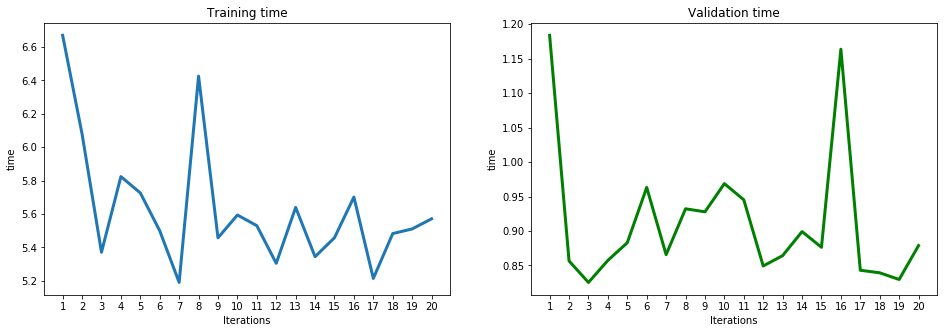

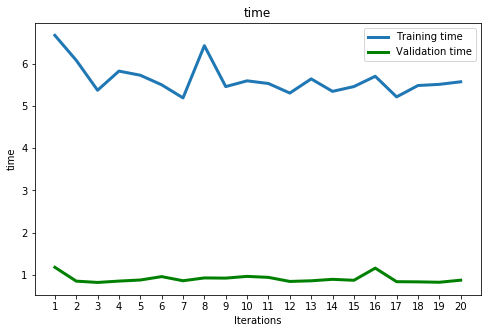

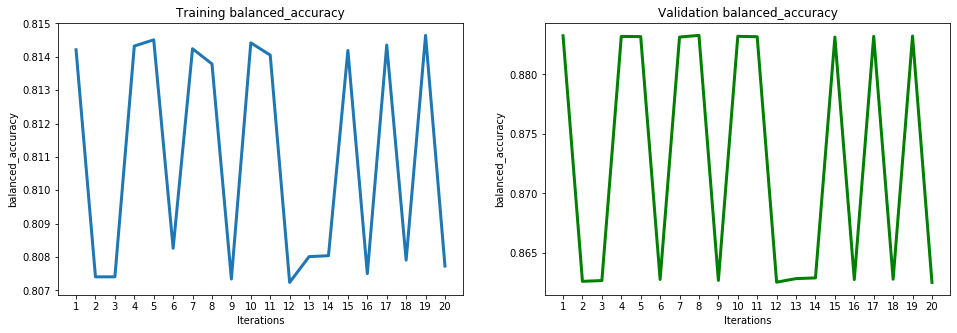

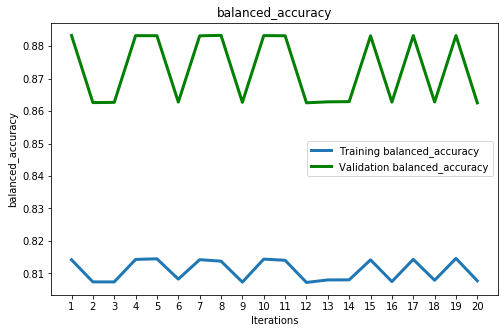

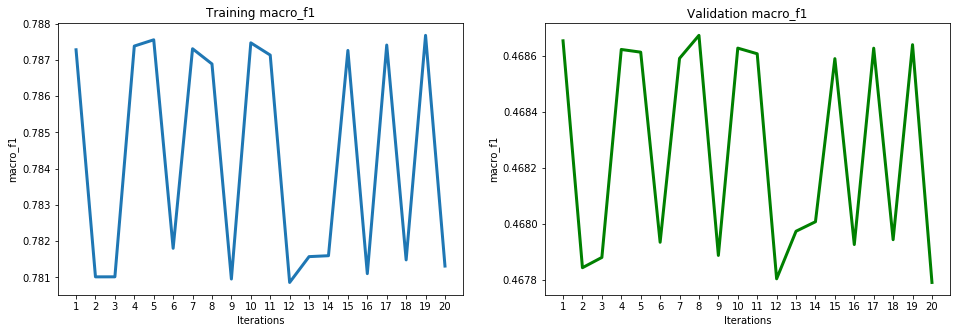

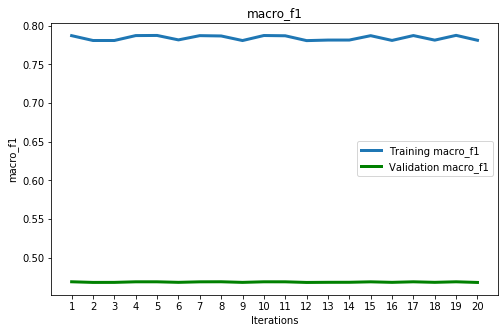

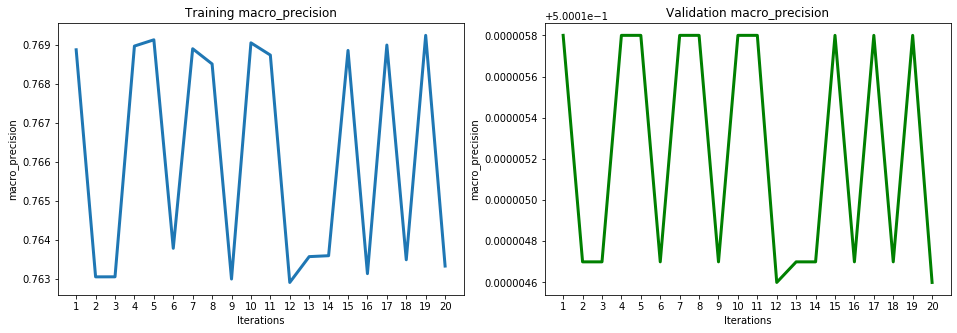

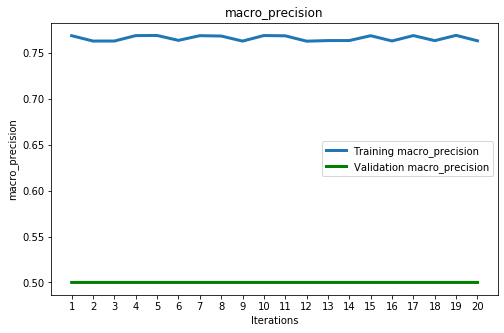

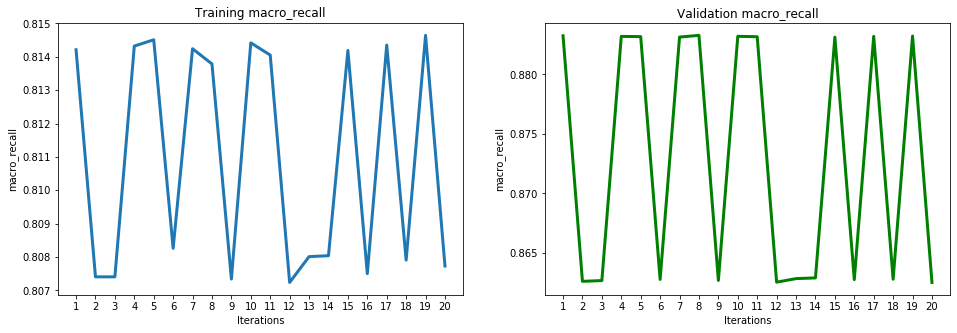

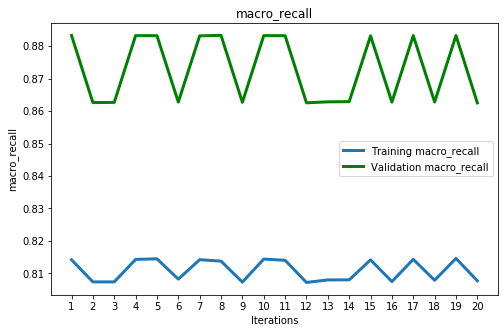

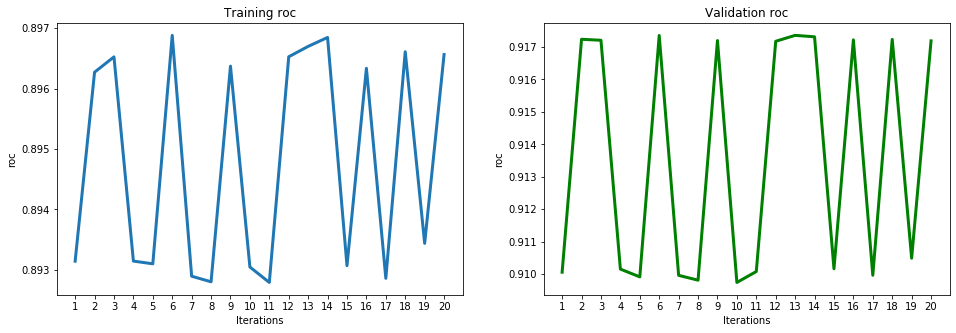

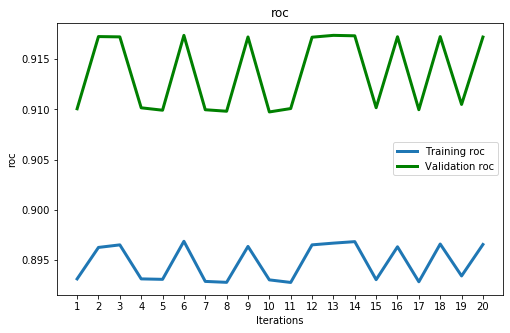

In [32]:
#metrics = ['time', 'accuracy', 'balanced_accuracy', 'f1', 'macro_f1', 'precision', 'macro_precision', 'recall', 'macro_recall', 'roc', 'macro_roc']
metrics = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
for metric in metrics:    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    plt.figure(figsize=(8, 5))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

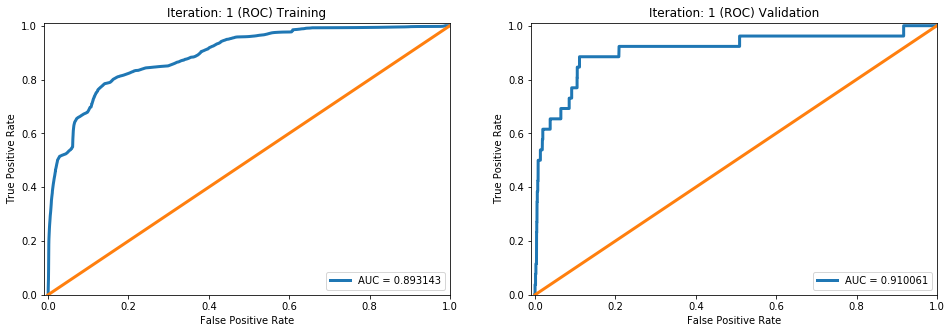

<Figure size 432x288 with 0 Axes>

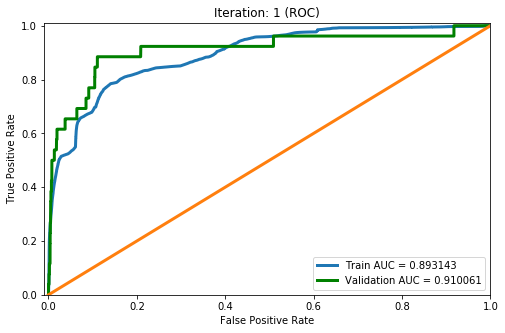

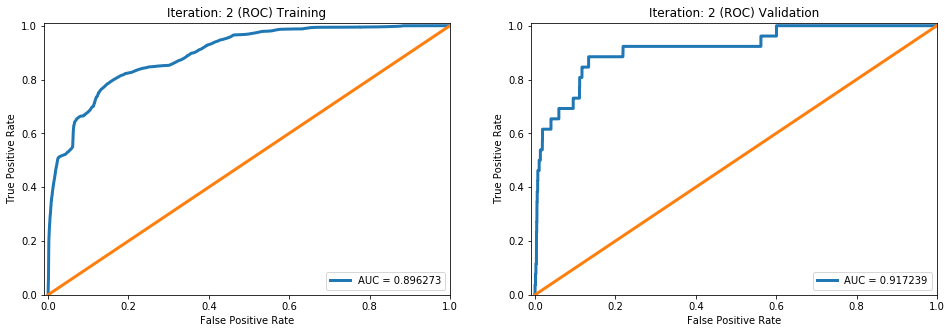

<Figure size 432x288 with 0 Axes>

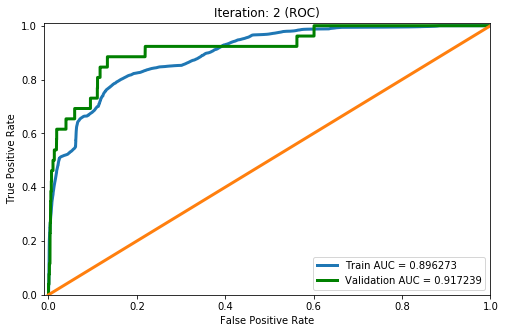

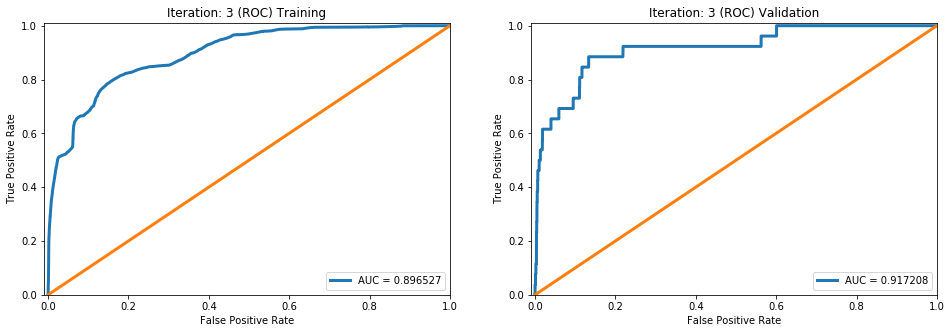

<Figure size 432x288 with 0 Axes>

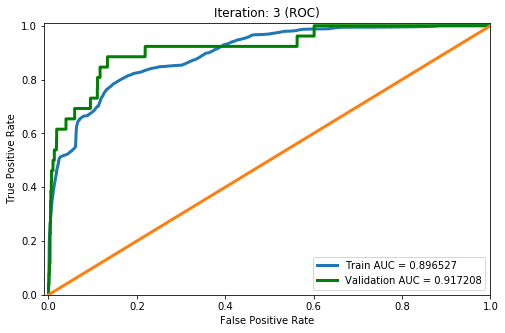

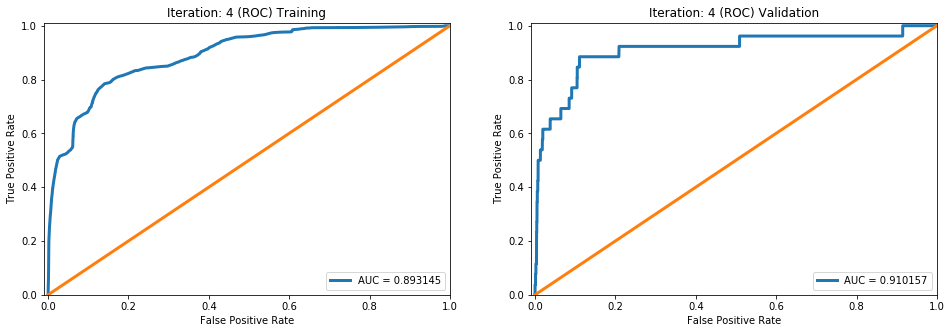

<Figure size 432x288 with 0 Axes>

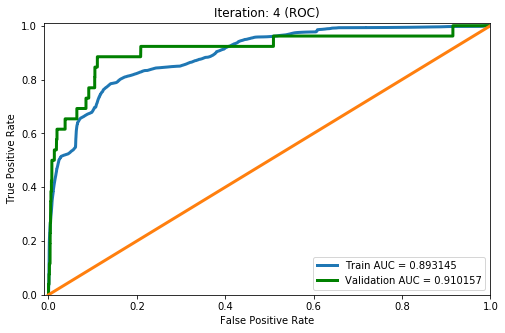

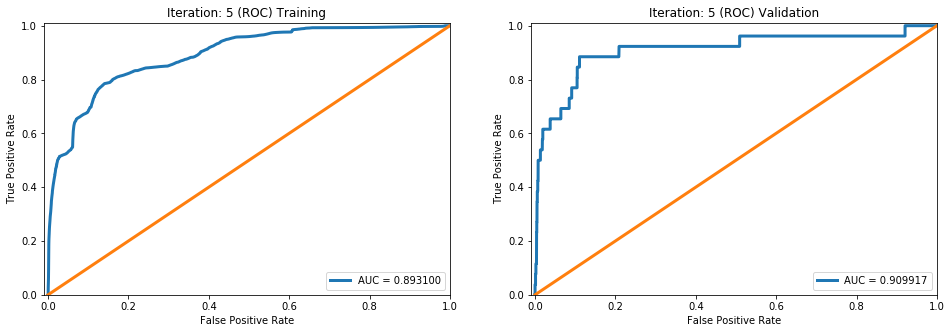

<Figure size 432x288 with 0 Axes>

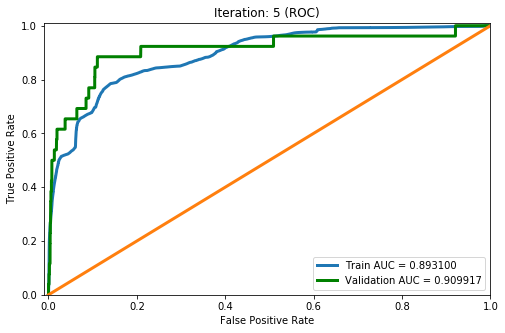

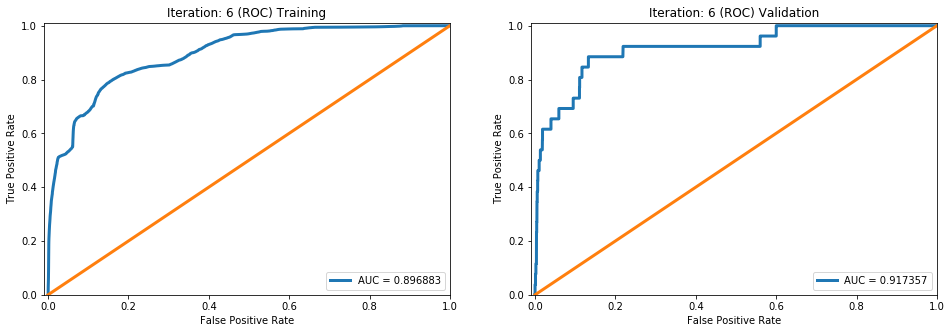

<Figure size 432x288 with 0 Axes>

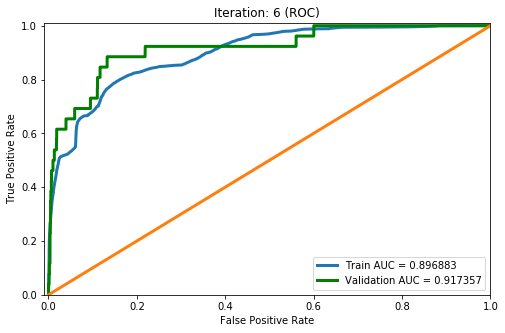

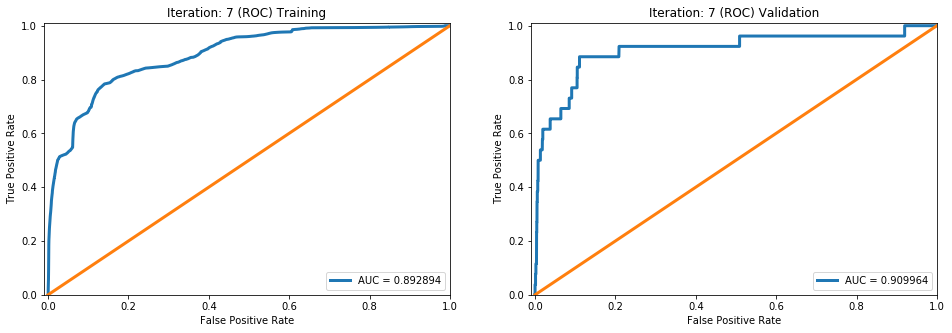

<Figure size 432x288 with 0 Axes>

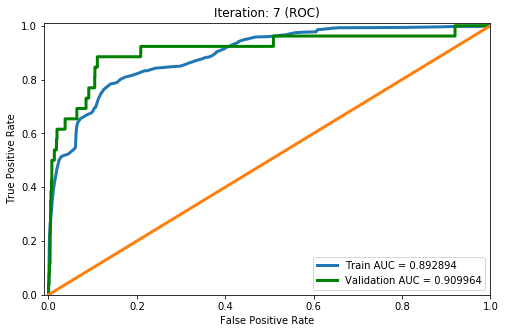

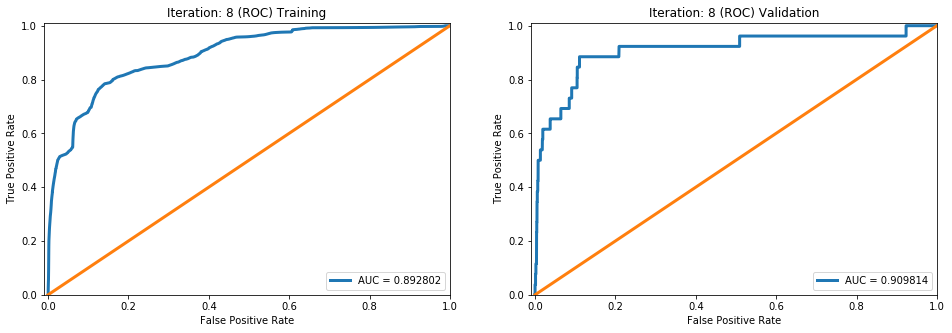

<Figure size 432x288 with 0 Axes>

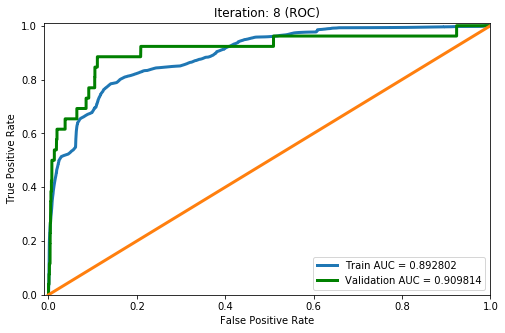

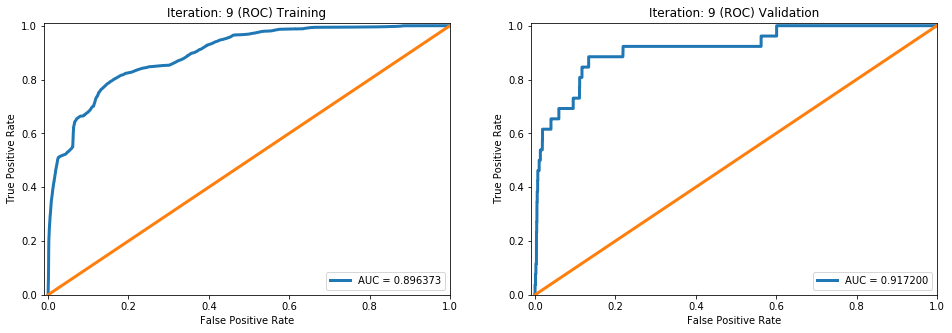

<Figure size 432x288 with 0 Axes>

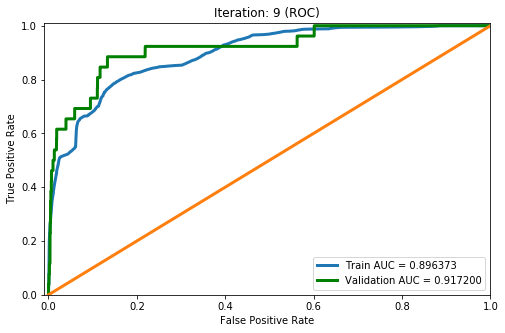

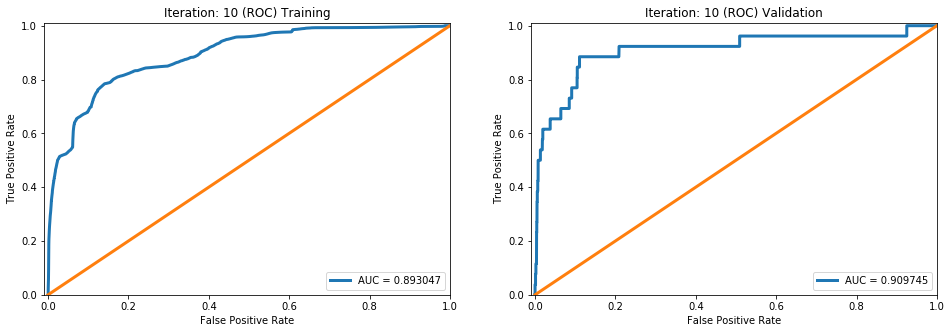

<Figure size 432x288 with 0 Axes>

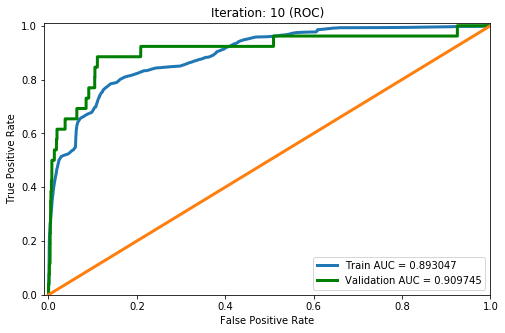

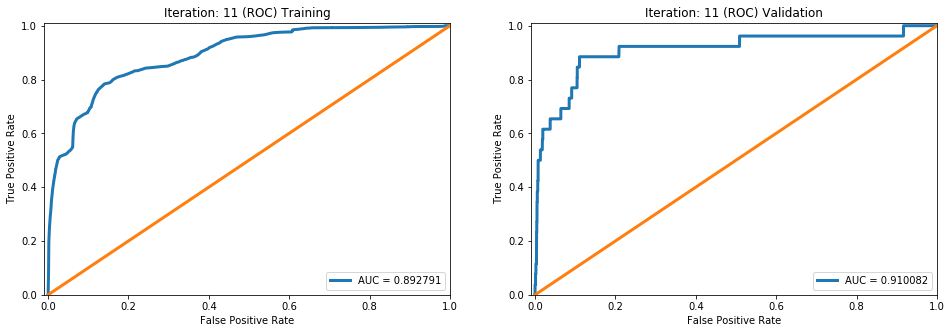

<Figure size 432x288 with 0 Axes>

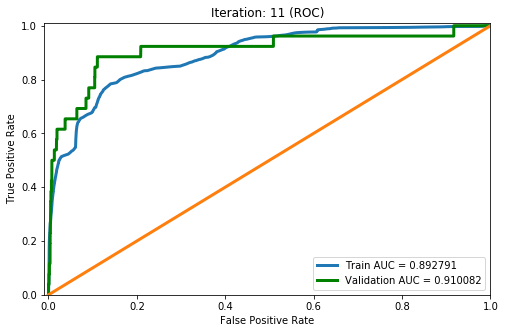

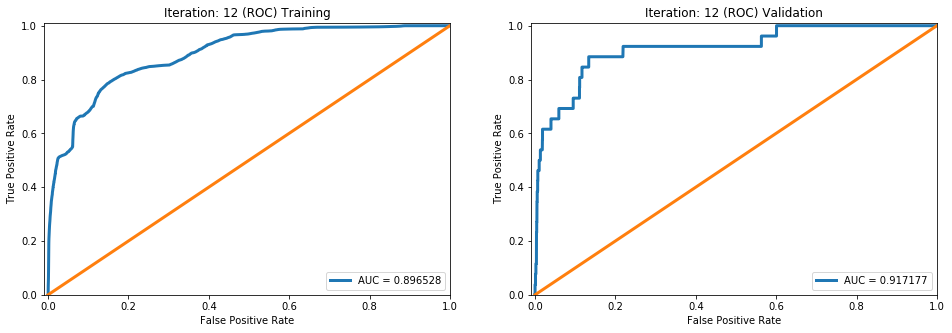

<Figure size 432x288 with 0 Axes>

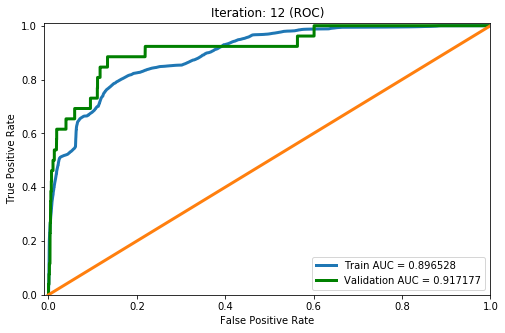

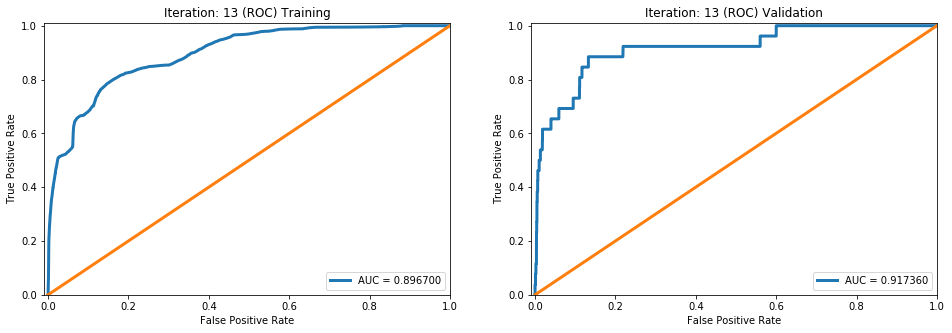

<Figure size 432x288 with 0 Axes>

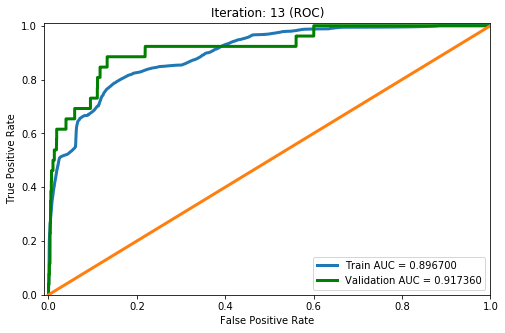

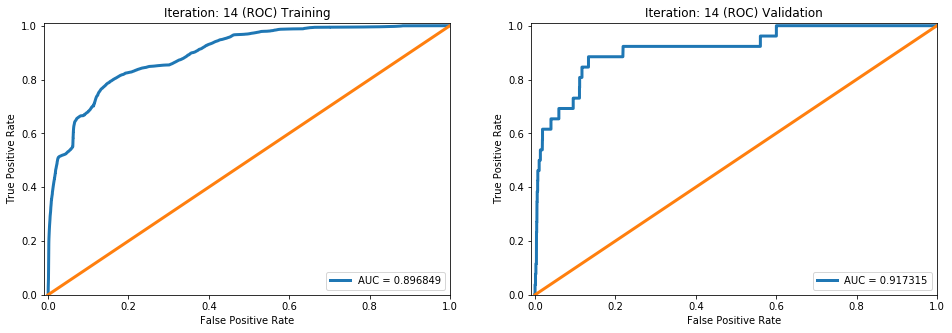

<Figure size 432x288 with 0 Axes>

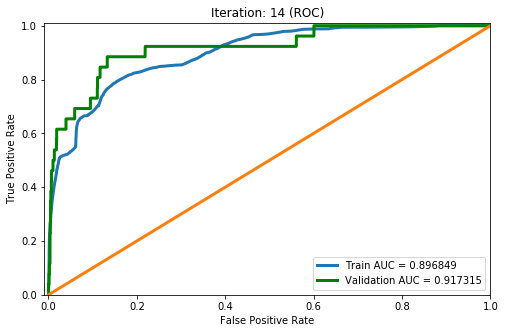

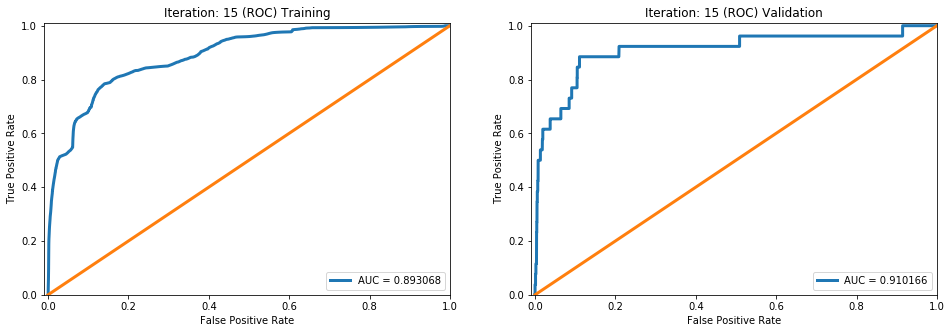

<Figure size 432x288 with 0 Axes>

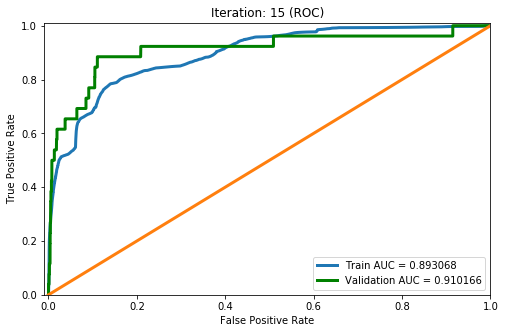

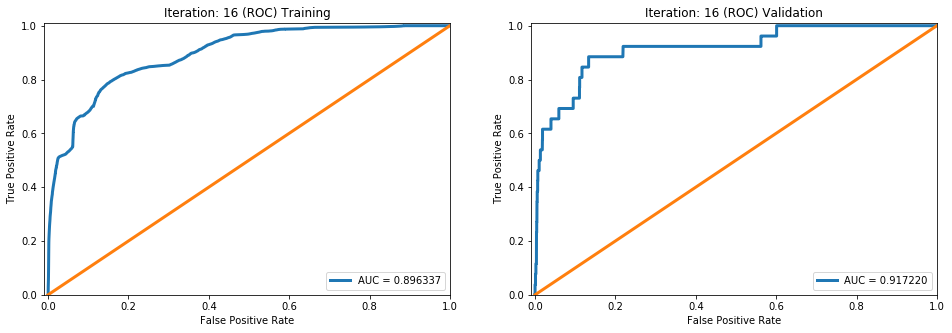

<Figure size 432x288 with 0 Axes>

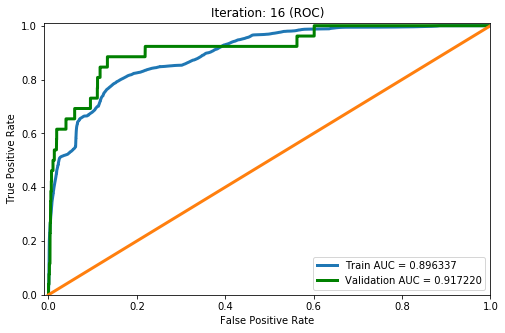

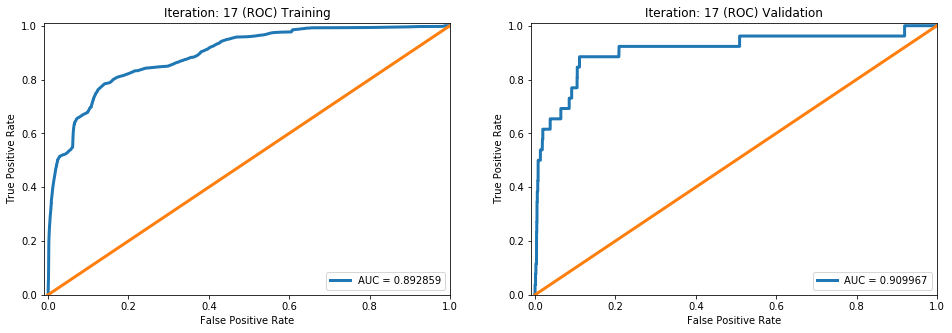

<Figure size 432x288 with 0 Axes>

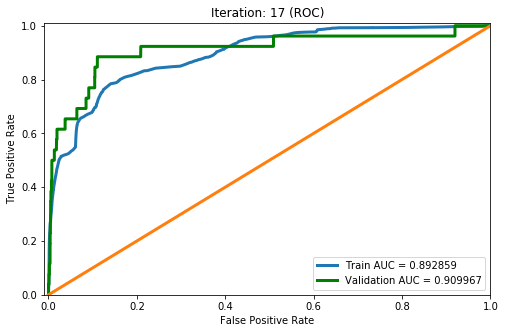

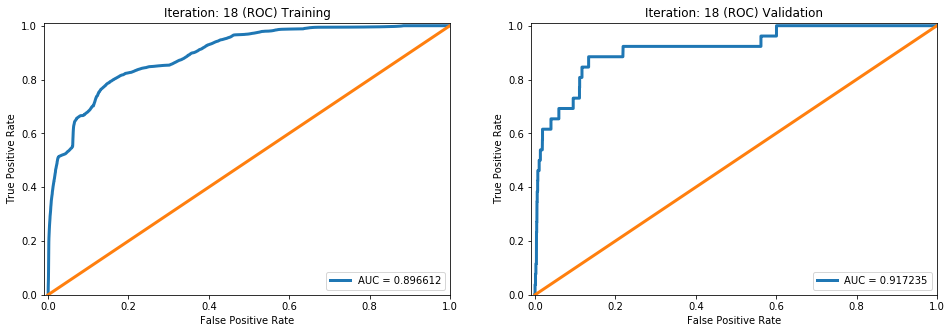

<Figure size 432x288 with 0 Axes>

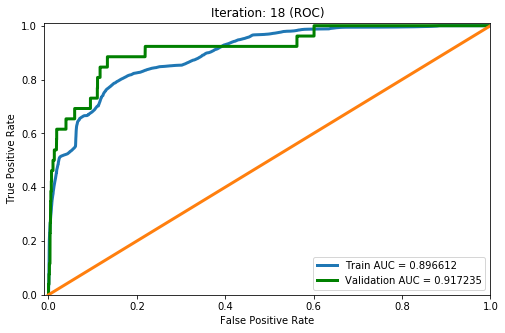

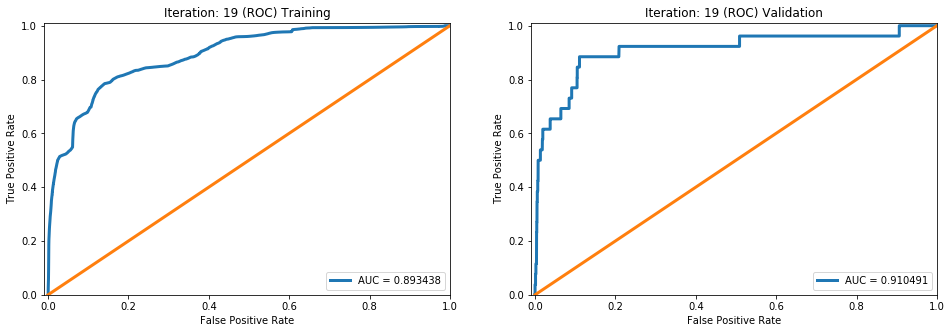

<Figure size 432x288 with 0 Axes>

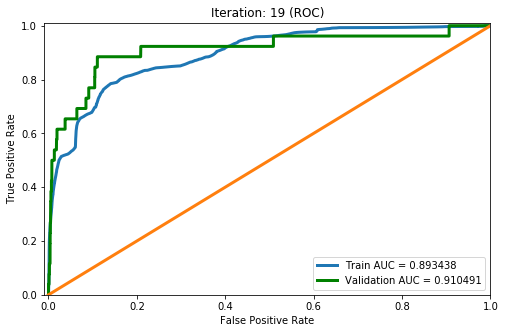

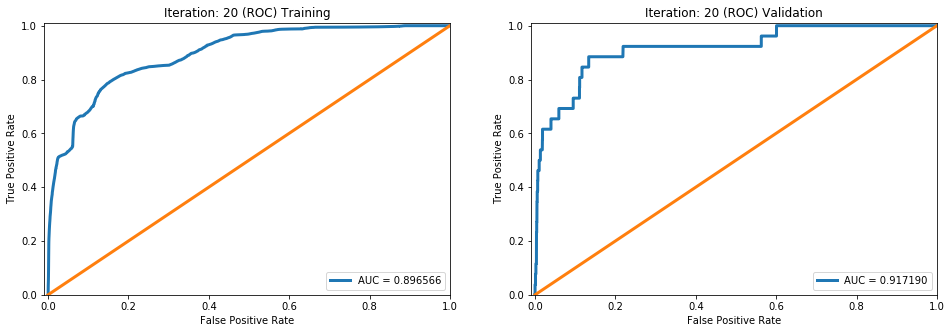

<Figure size 432x288 with 0 Axes>

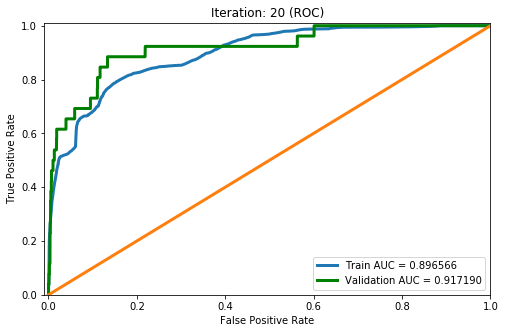

In [33]:
for it in iterations:
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
    ax1.plot([0,1],[0,1], linewidth=3)

    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    
    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)
    
    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
    ax2.plot([0,1],[0,1], linewidth=3)

    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.figure(2)
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    plt.figure(figsize=(8, 5))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
    plt.plot([0,1],[0,1], linewidth=3)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

    plt.legend(loc='lower right')
    plt.title('Iteration: '+ str(it) +' (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

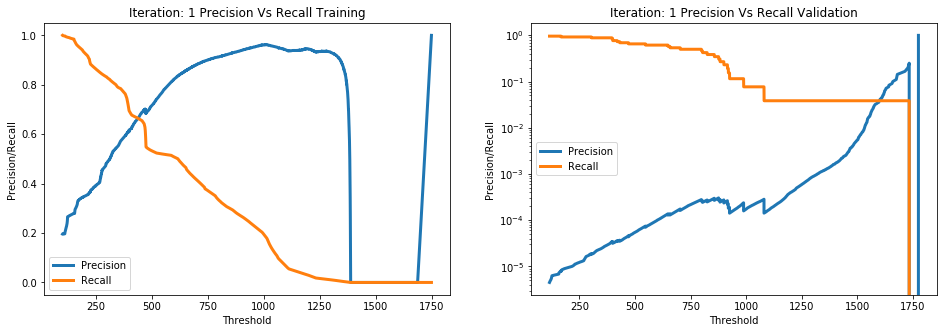

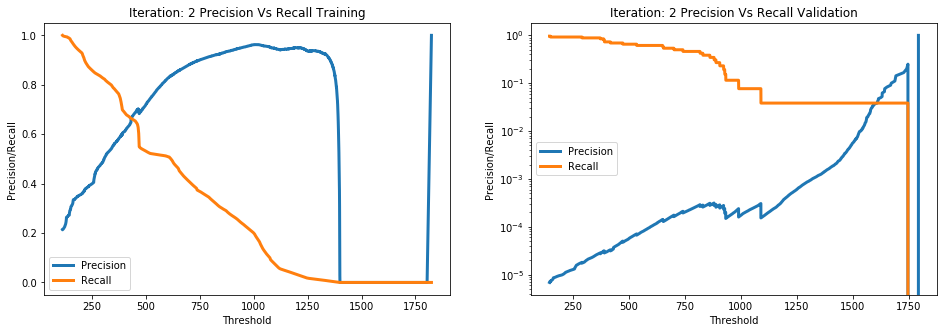

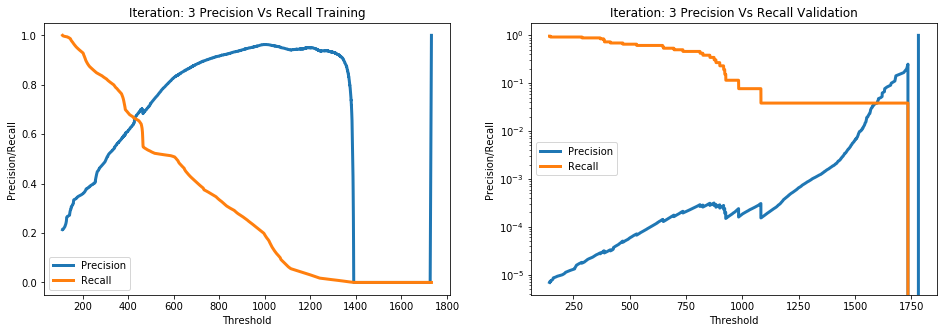

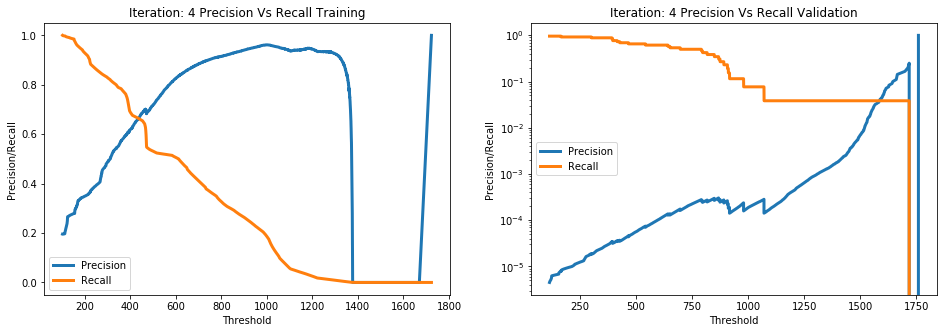

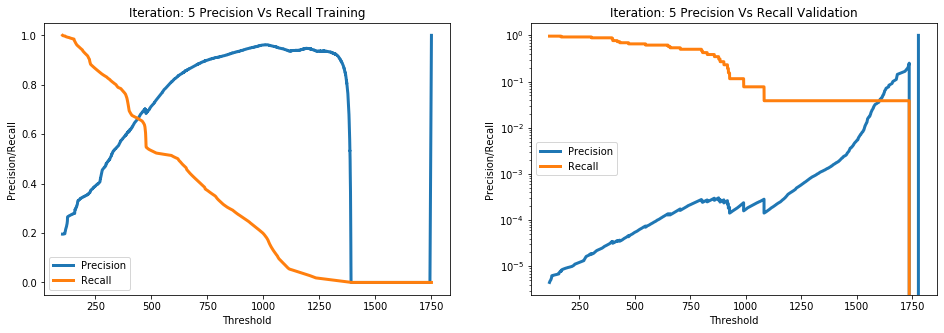

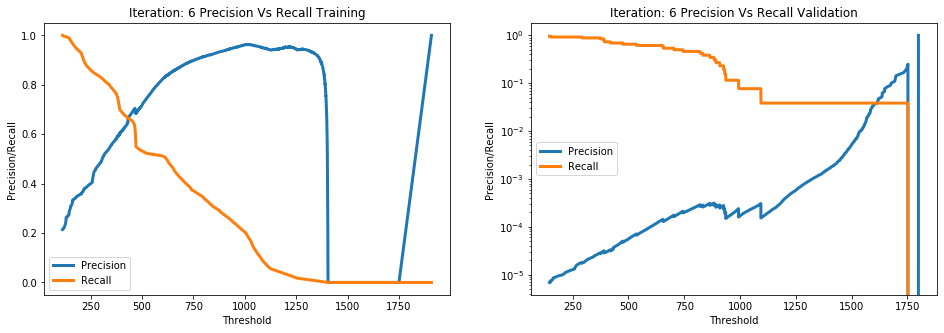

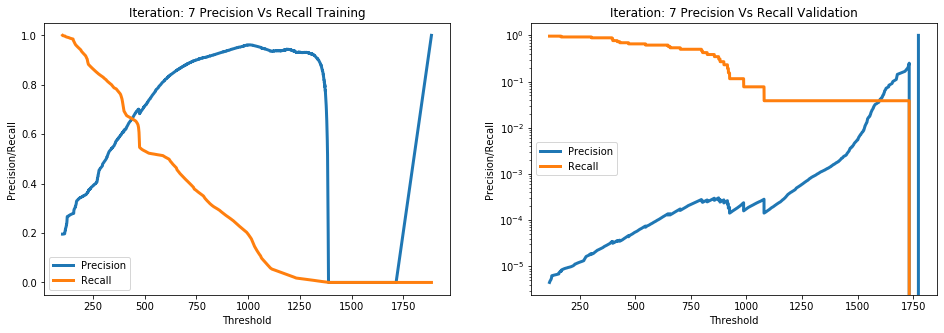

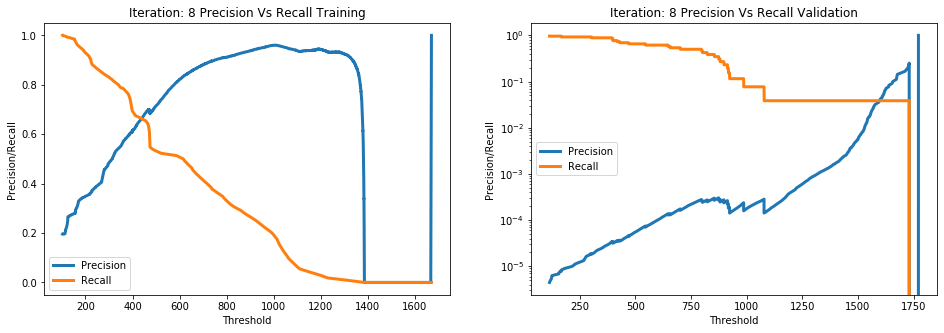

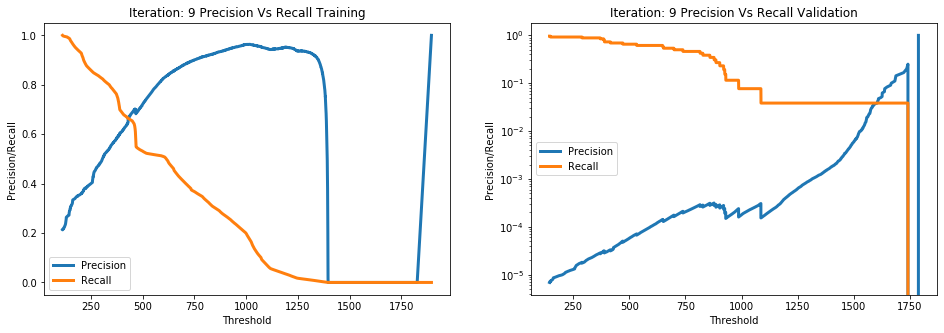

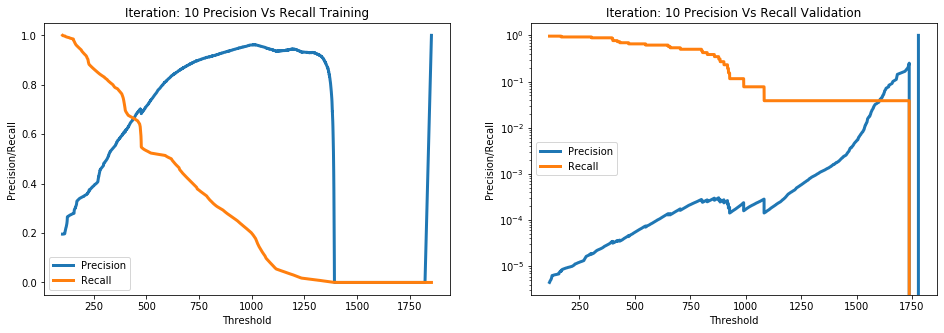

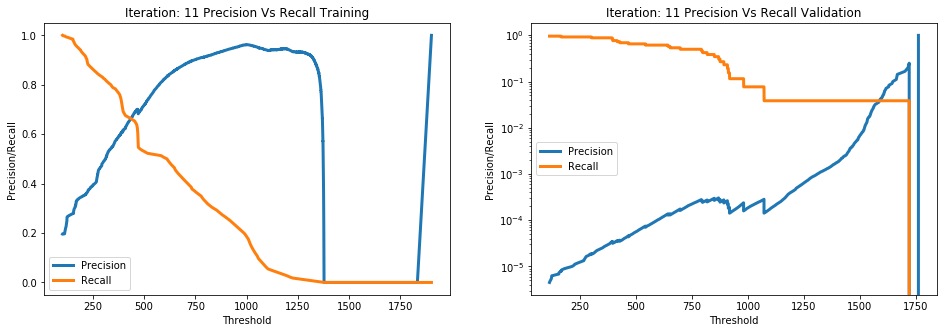

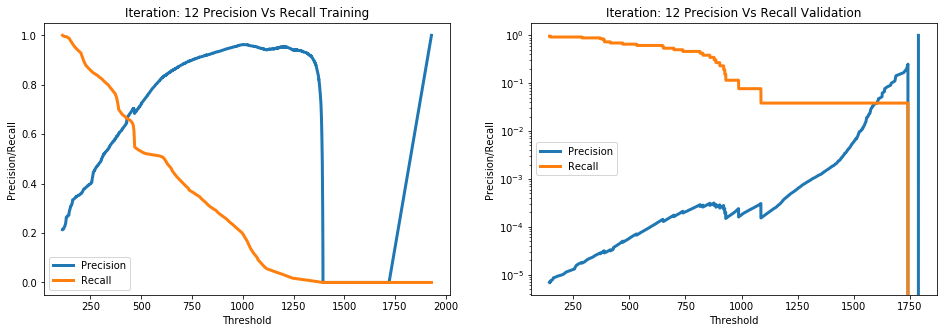

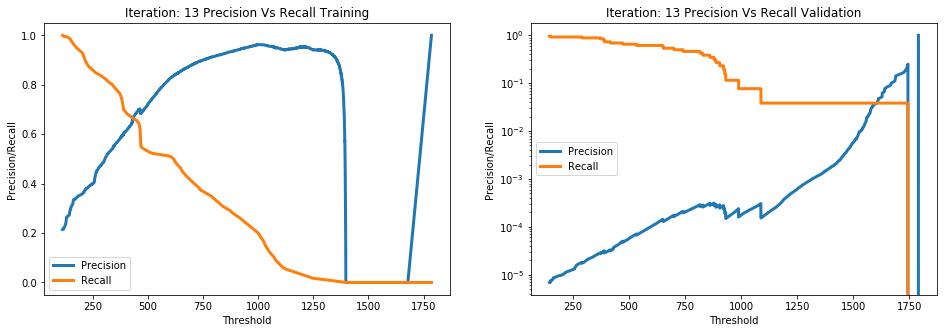

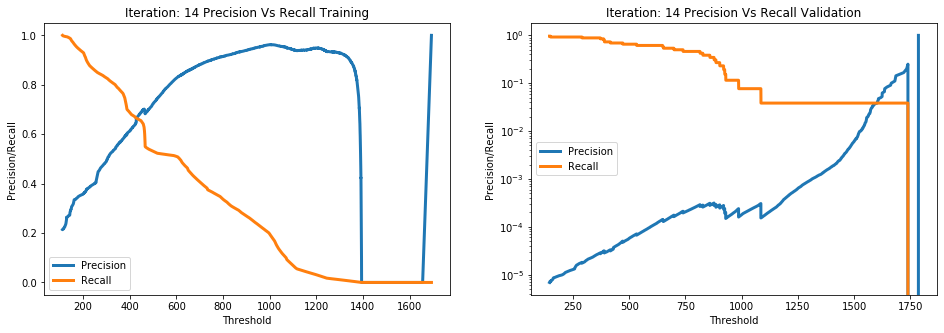

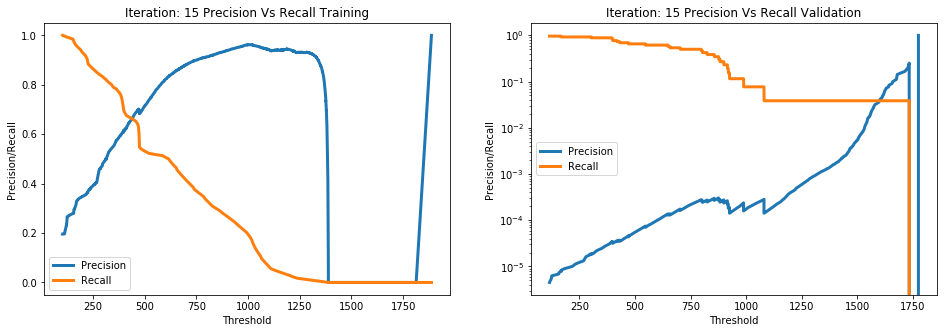

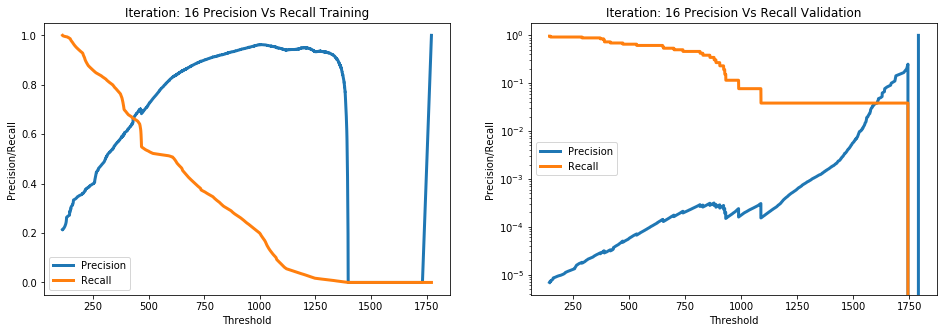

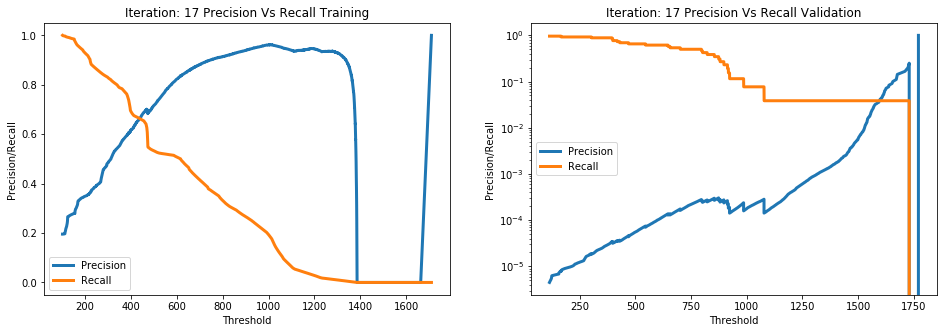

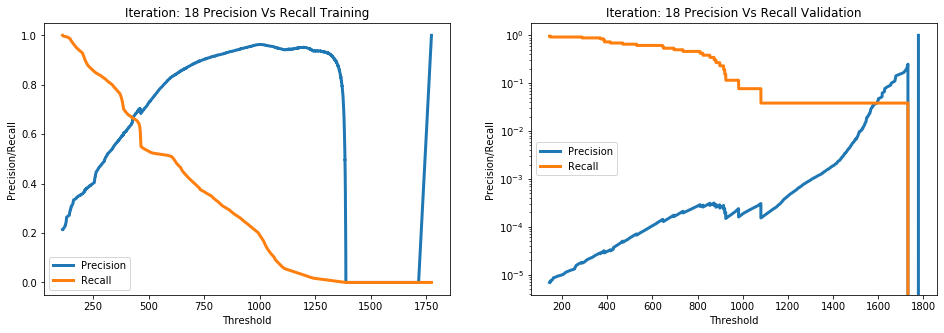

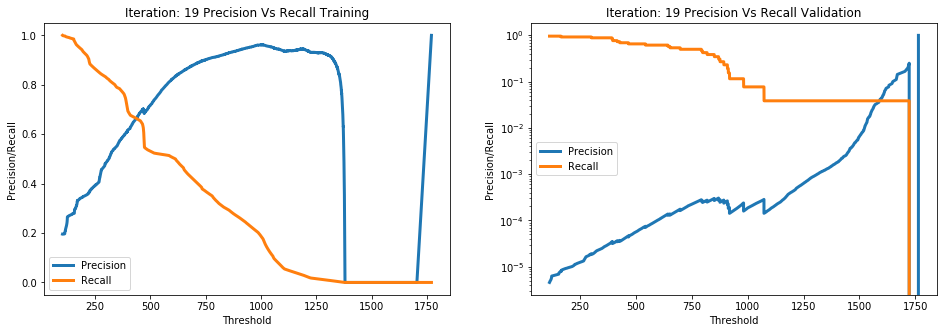

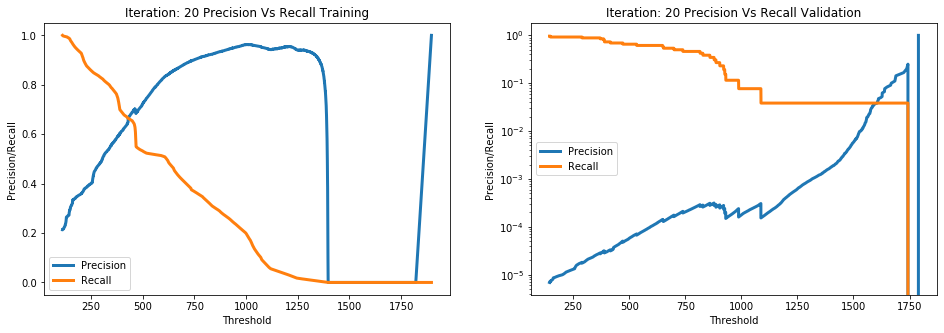

In [34]:
for it in iterations:
    precision_rt = training_evaluations[it]['precision_rt']
    recall_rt = training_evaluations[it]['recall_rt']
    threshold_rate = training_evaluations[it]['threshold_rt']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
    ax1.set_ylabel('Precision/Recall')
    ax1.set_xlabel('Threshold')
    
    
    precision_rt = test_evaluations[it]['precision_rt']
    recall_rt = test_evaluations[it]['recall_rt']
    threshold_rate = test_evaluations[it]['threshold_rt']
    ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
    ax2.set_ylabel('Precision/Recall')
    ax2.set_xlabel('Threshold')

# Confusion Matrix

In [35]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [36]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

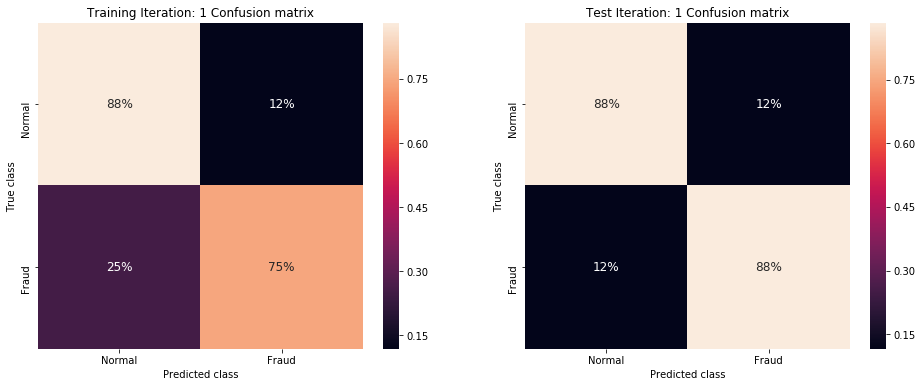

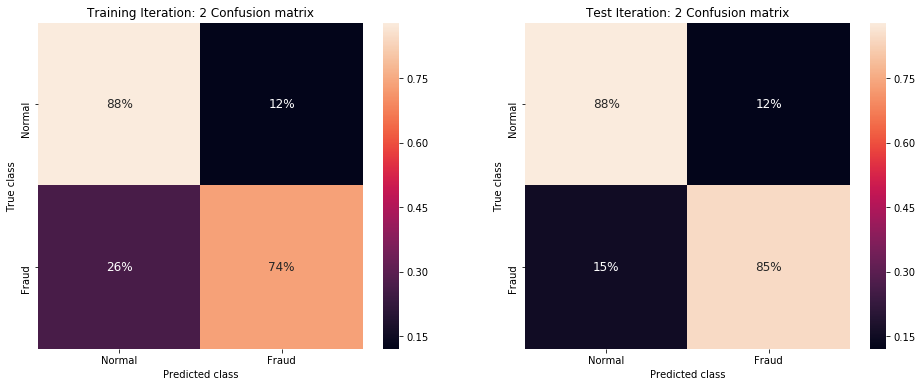

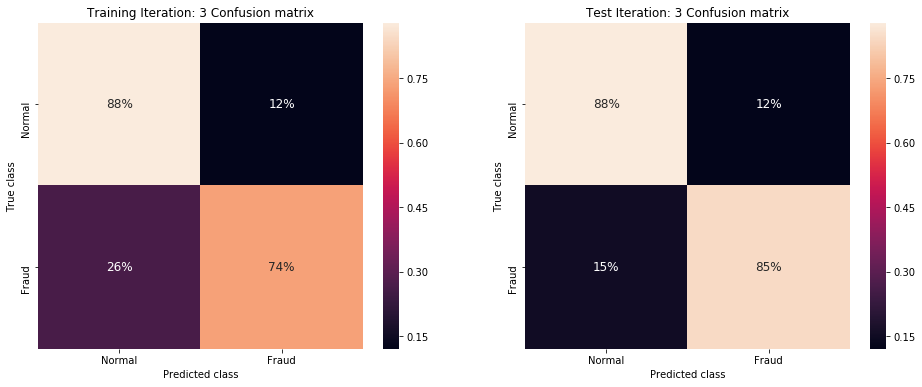

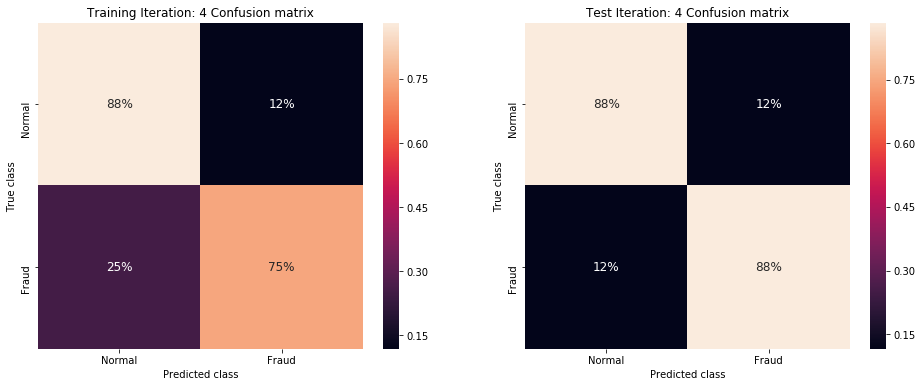

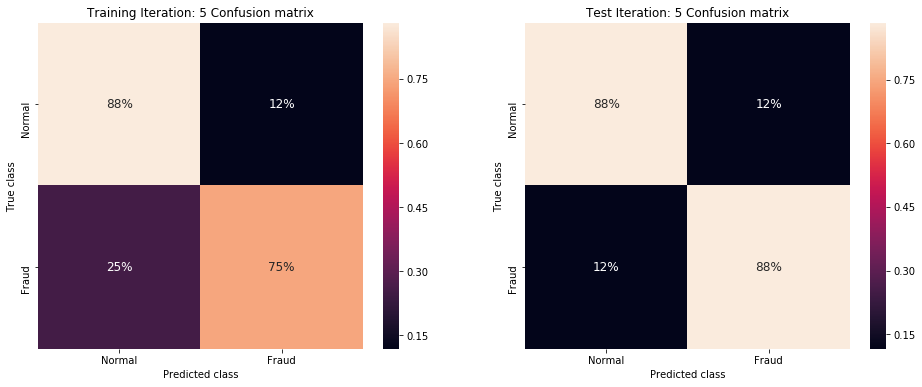

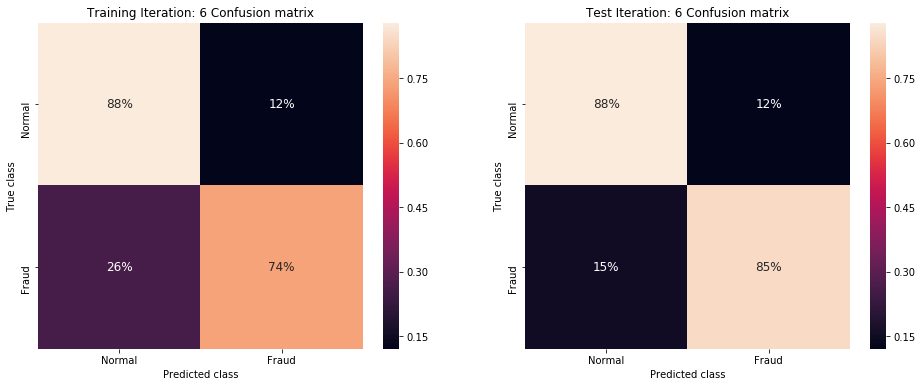

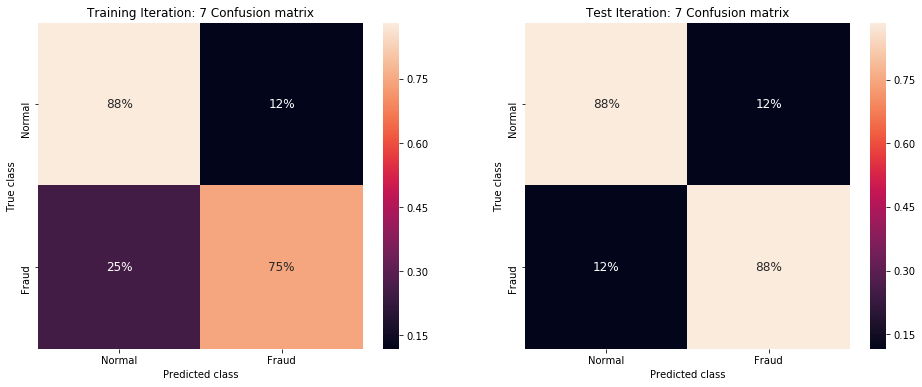

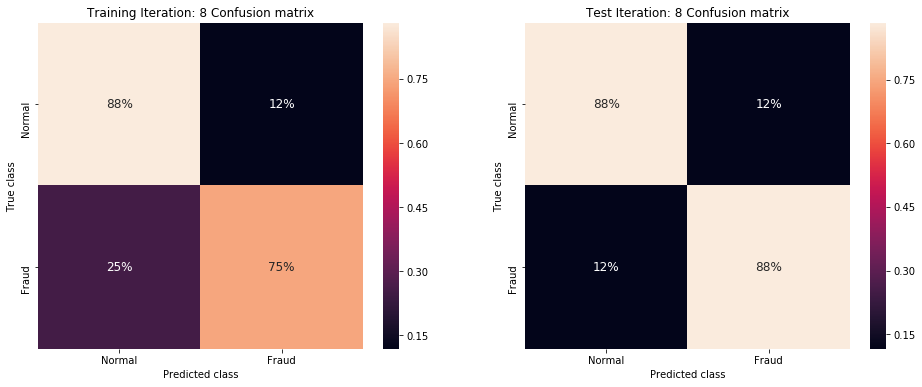

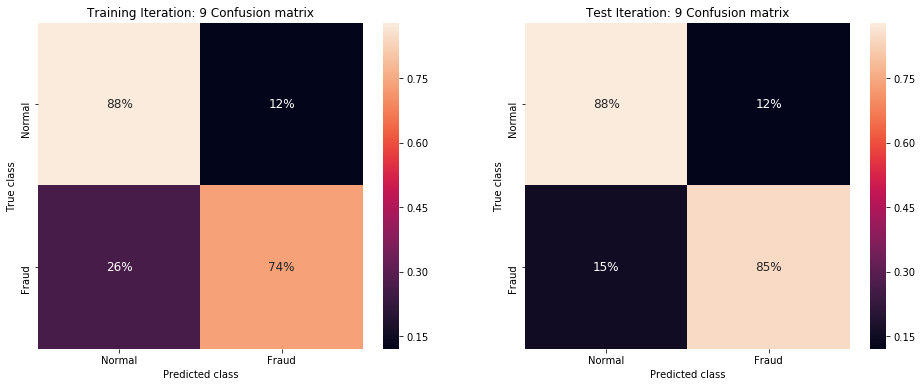

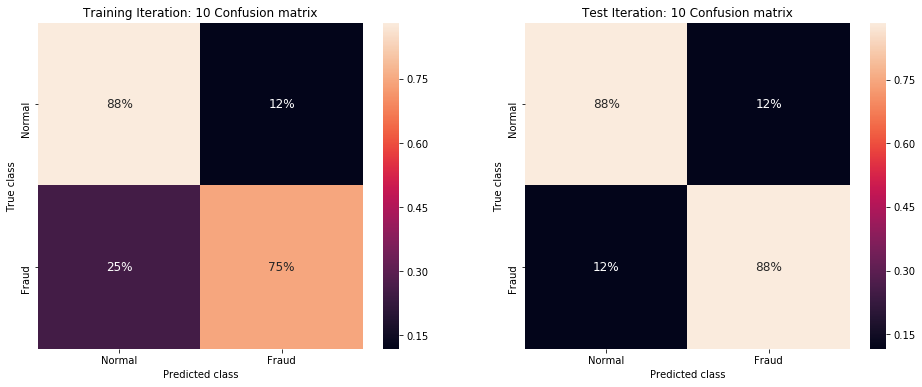

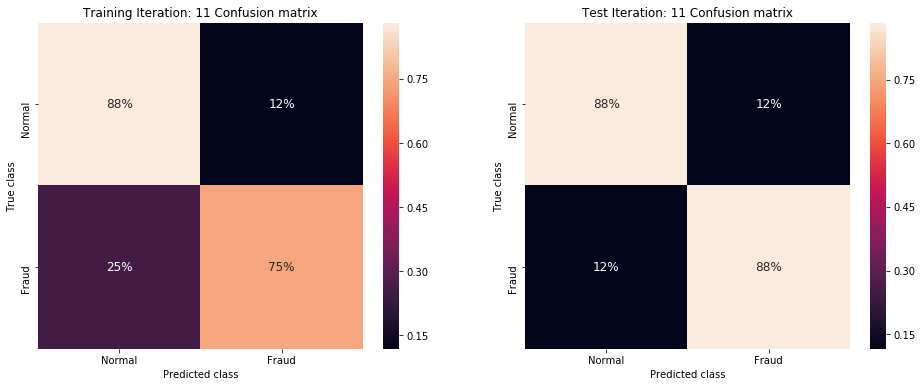

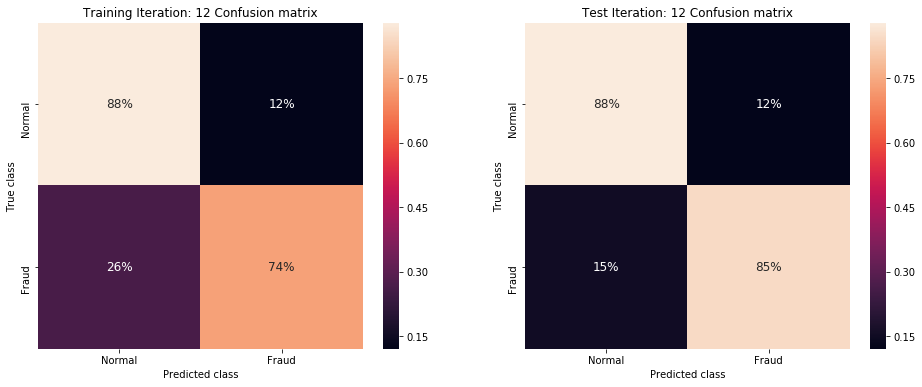

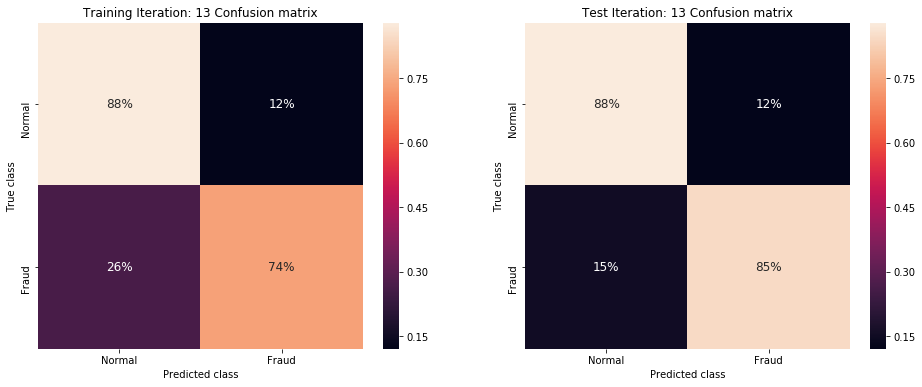

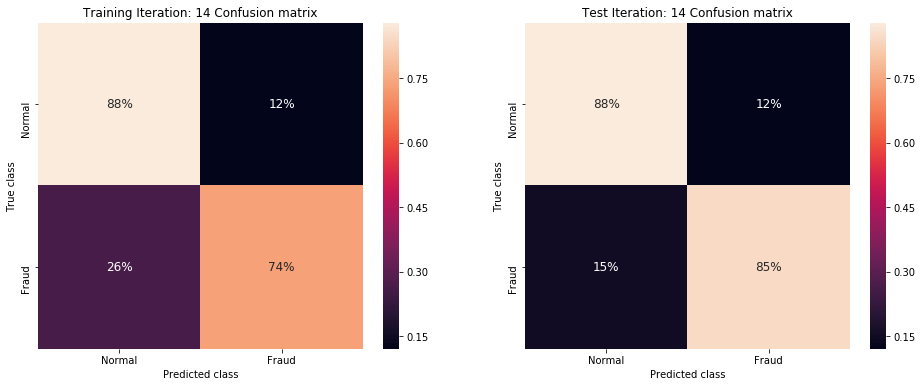

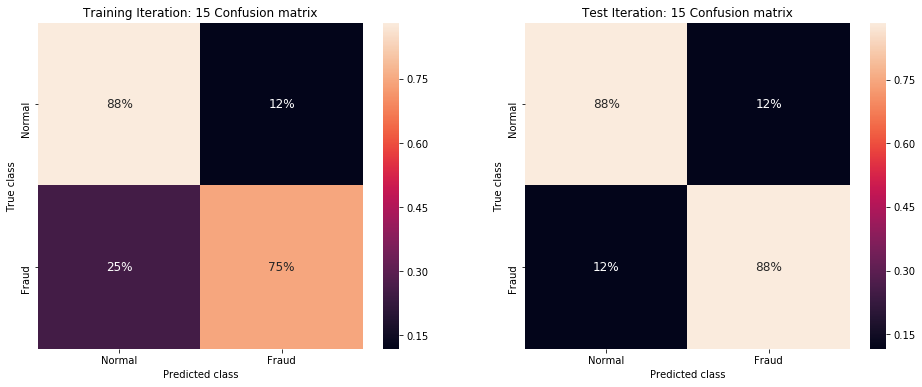

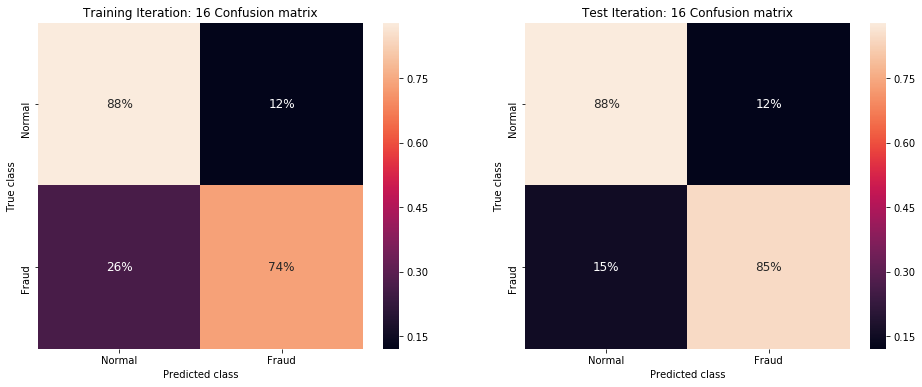

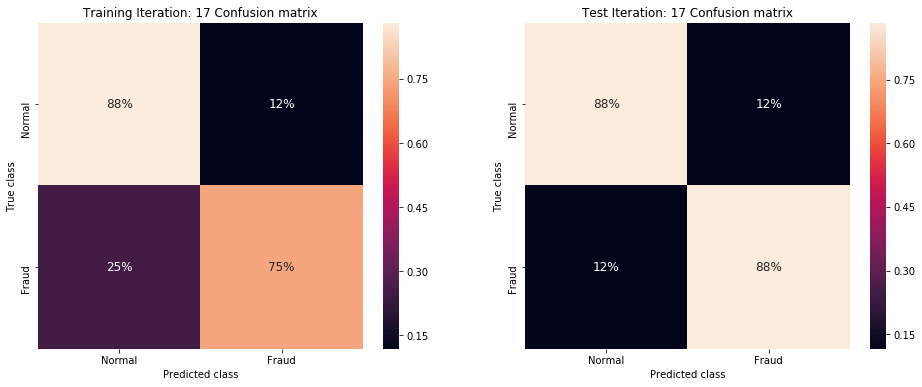

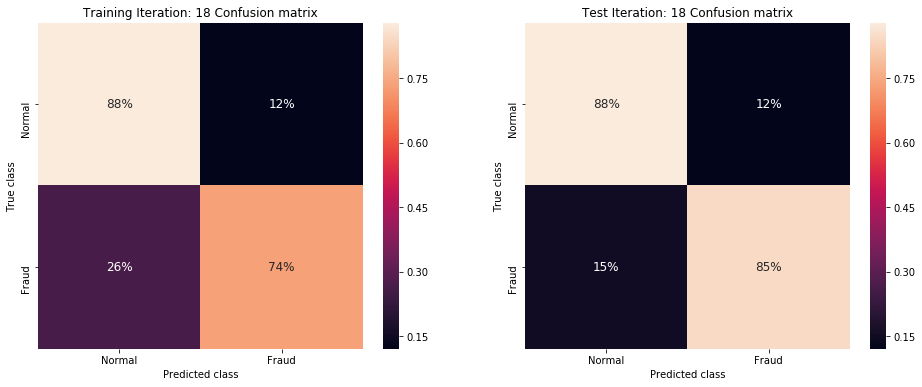

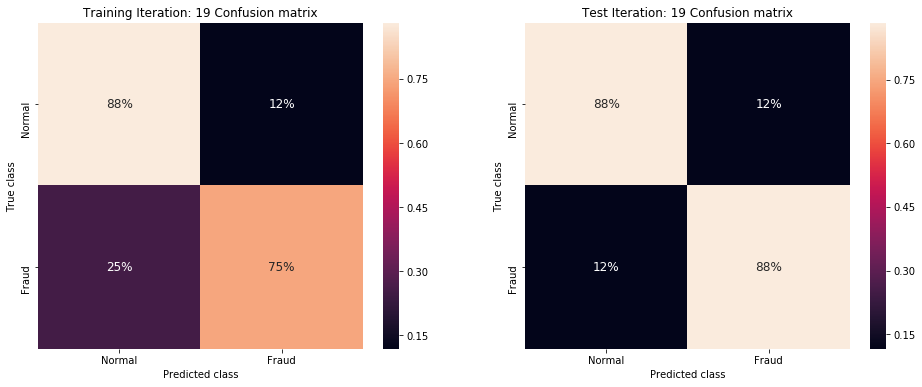

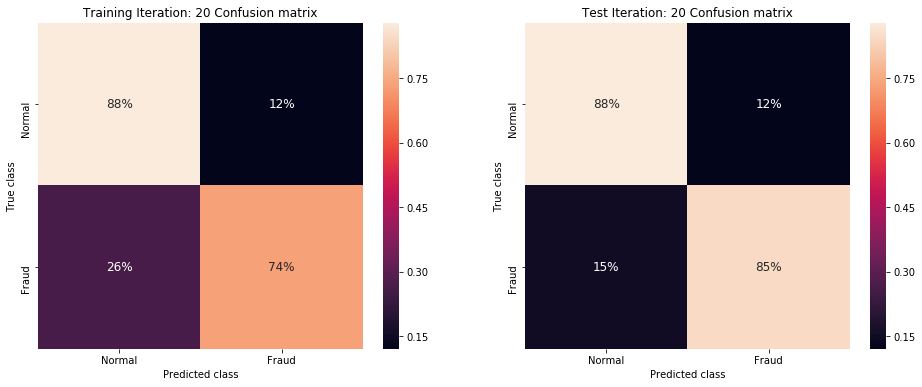

In [37]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

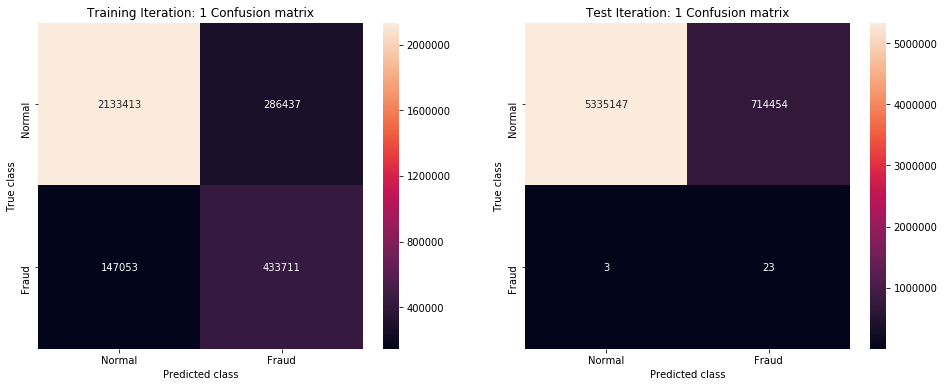

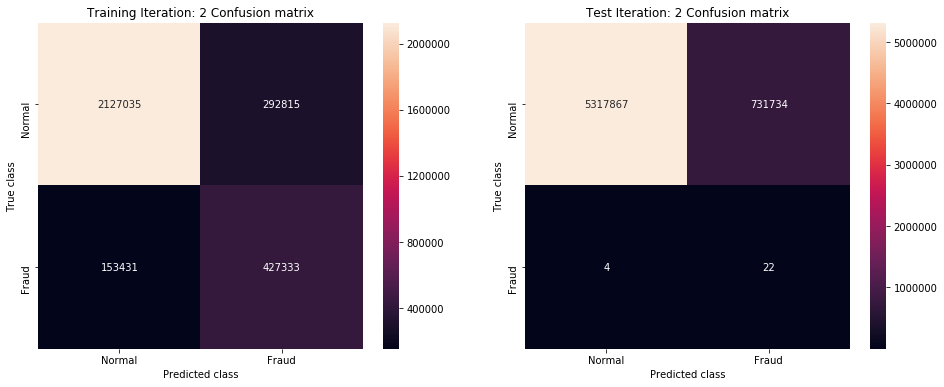

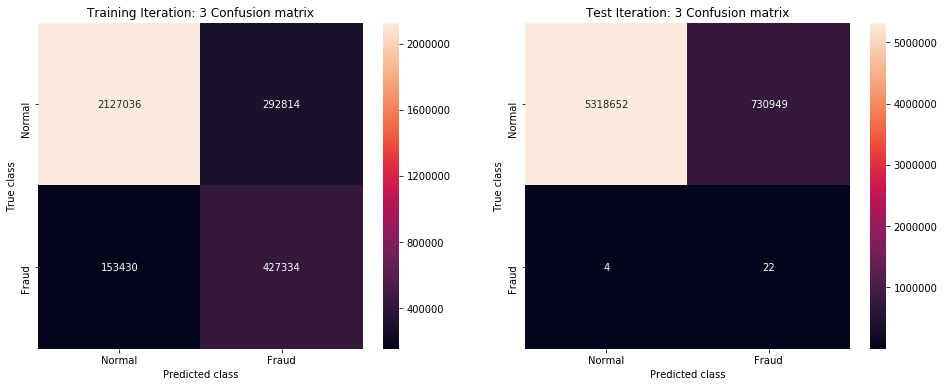

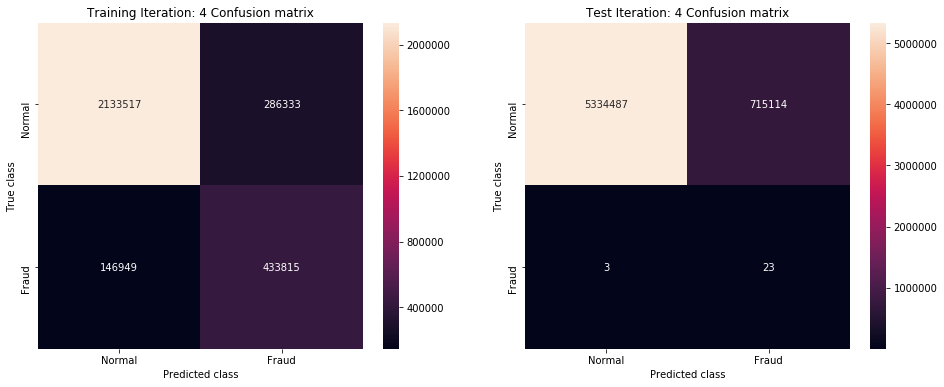

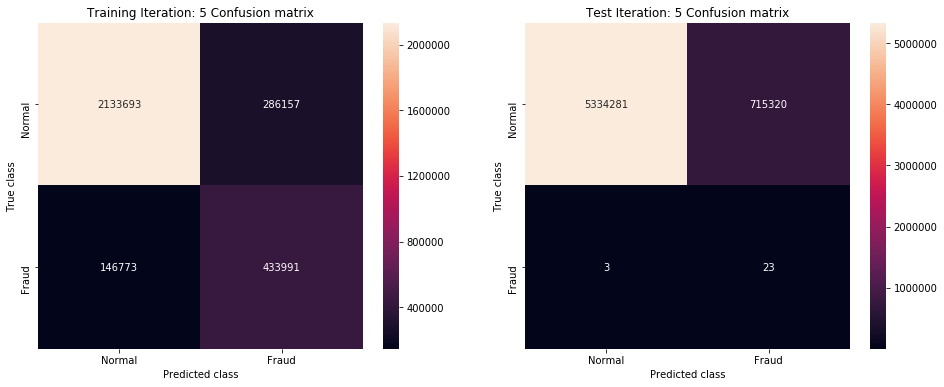

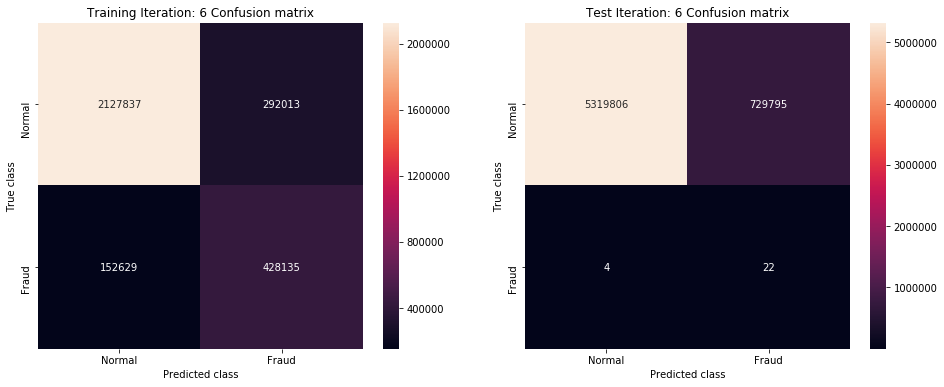

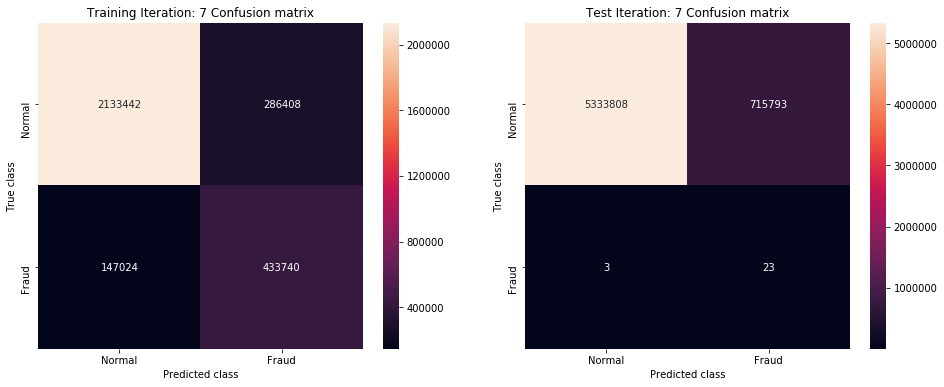

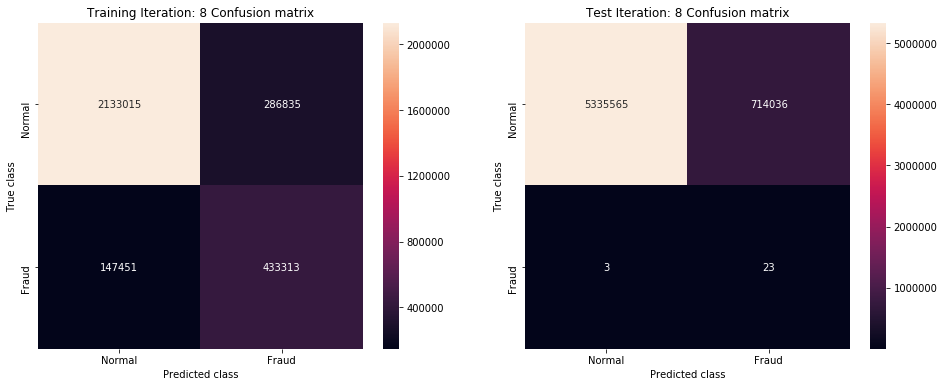

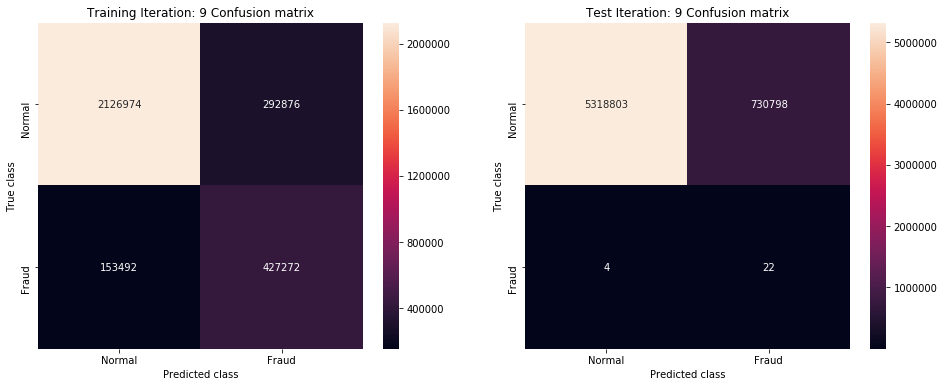

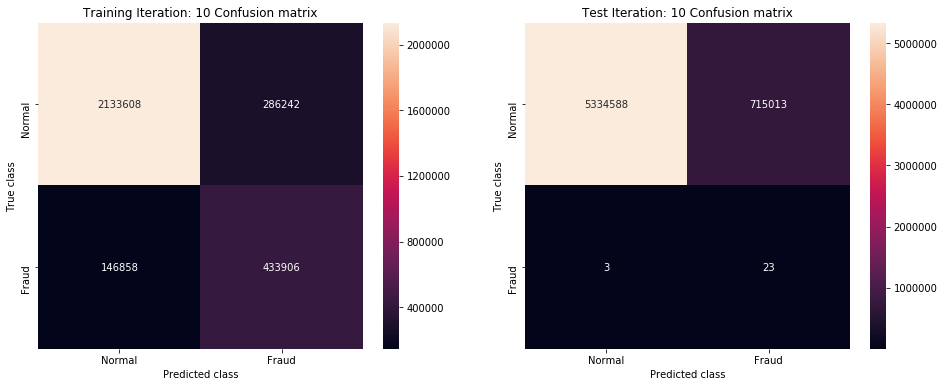

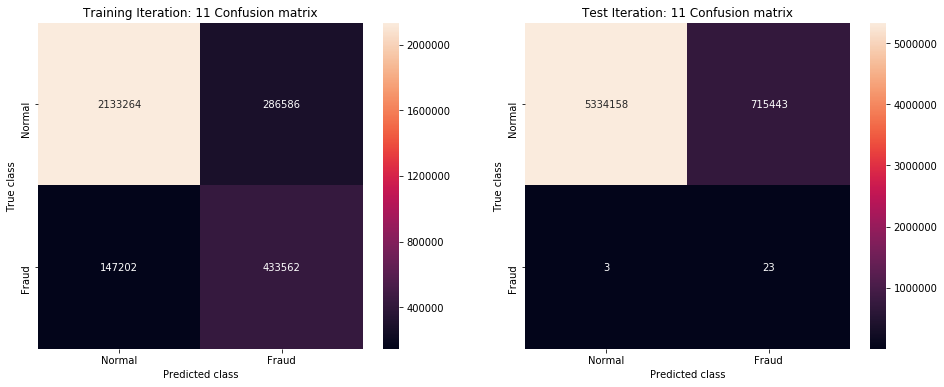

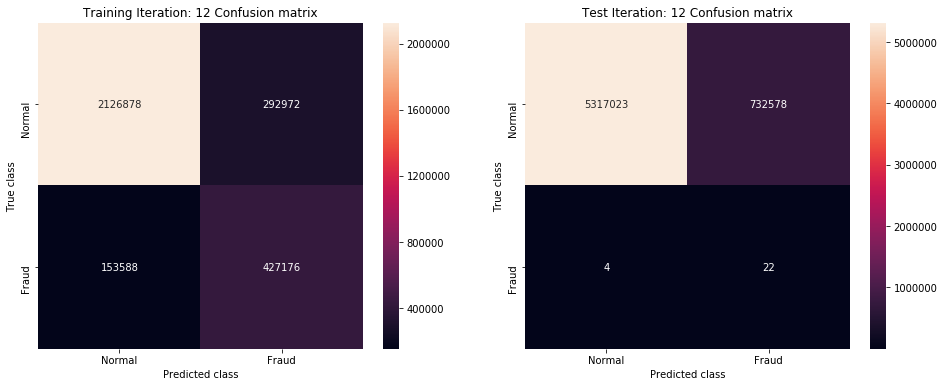

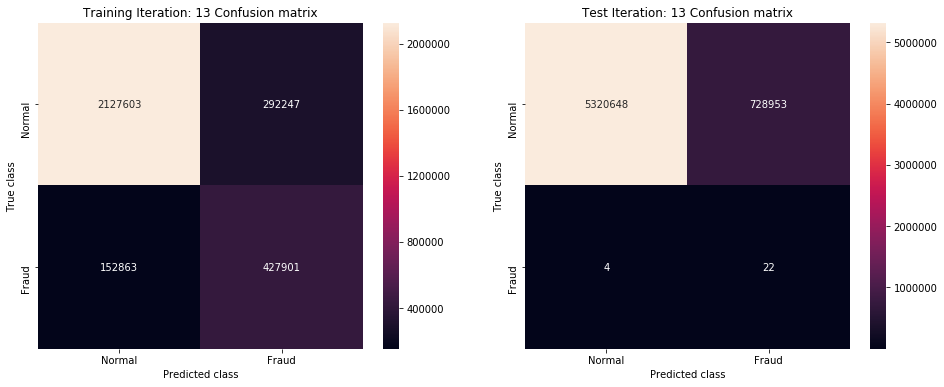

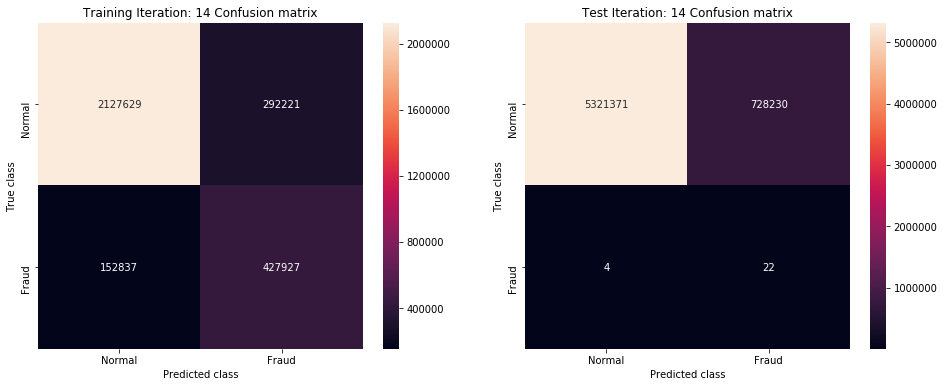

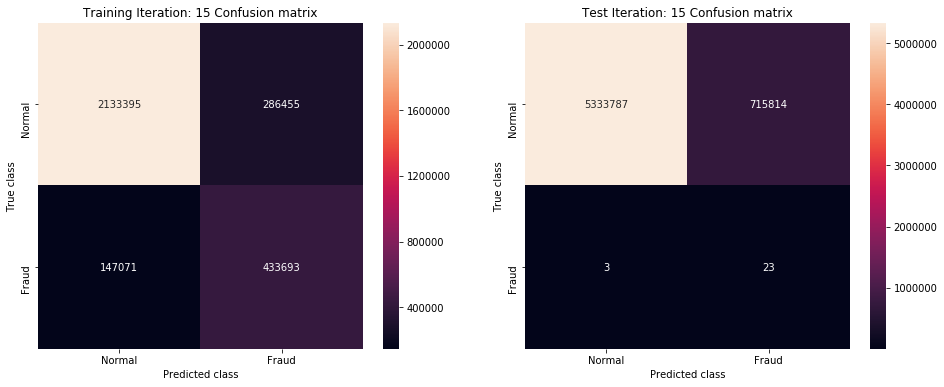

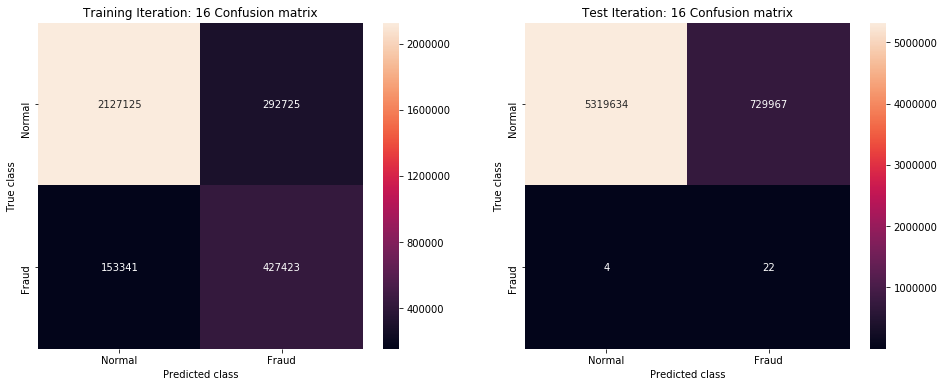

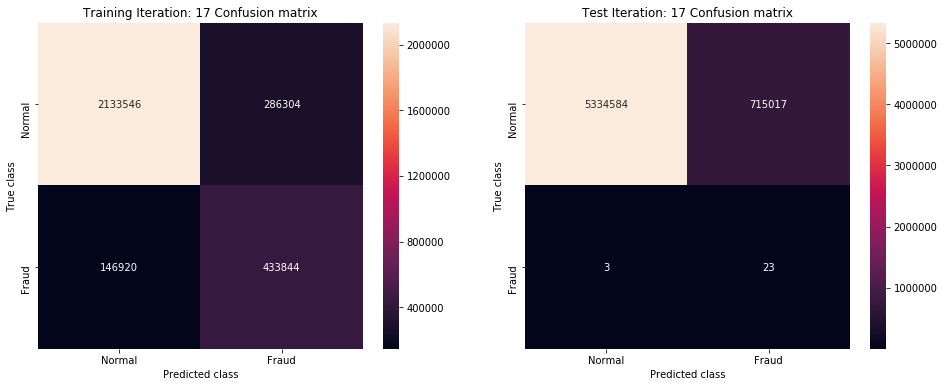

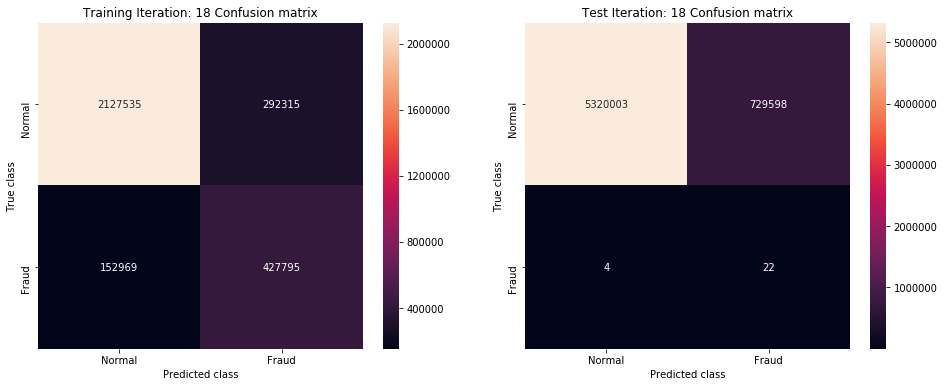

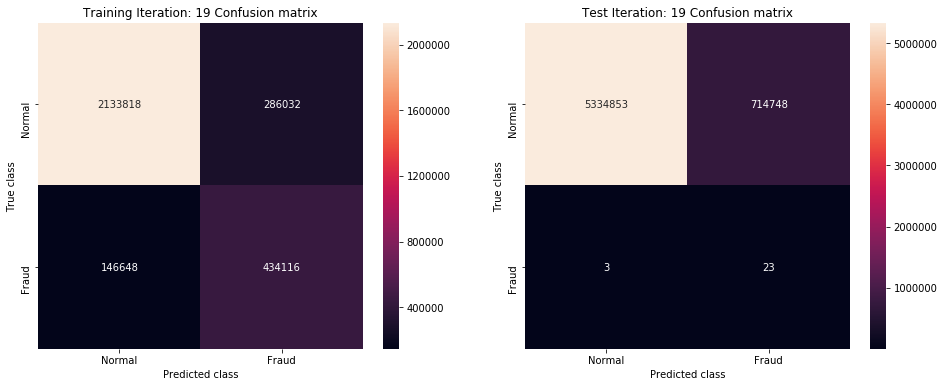

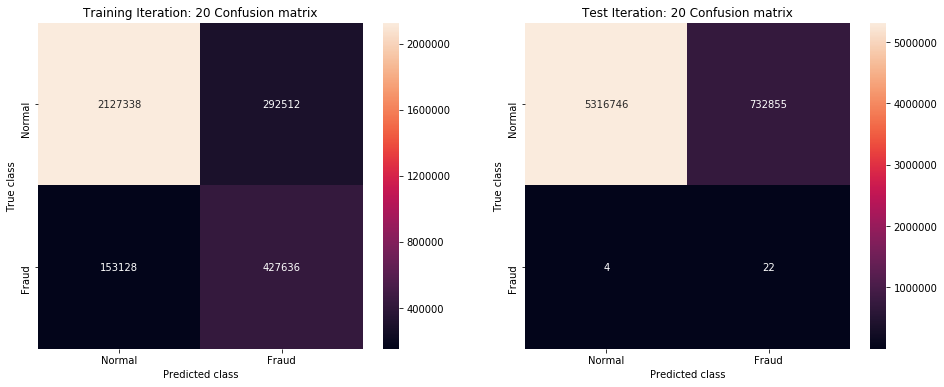

In [38]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, it)

# Parameter Tuning

In [35]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp
import random

space={
'n_components': hp.uniform('n_components', 1, 7),
'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25),
'tol': hp.uniform('tol', 0.0, 0.9)
}

random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
print('Training With:')
print(pd.value_counts(sample_ytrain))


def hyper_parm_opt(space):
    start = time.time()
    n_components = int(space['n_components'])
    n_selected_components = random.randint(1,n_components)
    outliers_fraction = space['outliers_fraction']
    tol = space['tol']
    print(n_components)
    print(n_selected_components)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = PCA(n_components=n_components, 
              n_selected_components=n_selected_components, 
              contamination=outliers_fraction, 
              copy=True, 
              whiten=False, 
              svd_solver='auto', 
              tol=tol, 
              iterated_power='auto', 
              random_state=random_state, 
              weighted=True, 
              standardization=False)
    clf.fit(X_train)
    y_train_pred = clf.labels_
    score = f1_score(y_train, y_train_pred, average="macro")
    val = 1 - score
    end = time.time()
    print('time: ' + str(round(end - start, 4)) + ' seconds')
    print('params: '+ str(space))
    print('val: ' + str(val))
    print('')
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=500, trials=trials)


print('\n\n\nbest: {}'.format(best))

Training With:
0    2419850
1         82
dtype: int64
6
2
time: 3.3935 seconds
params: {'n_components': 6.031387707787557, 'outliers_fraction': 0.11640649544298039, 'tol': 0.3370377354422138}
val: 0.25173002362362795

4
1
time: 8.2411 seconds
params: {'n_components': 4.634778473582207, 'outliers_fraction': 0.16756157895792193, 'tol': 0.24945375799395045}
val: 0.22701306957280343

3
3
time: 9.4923 seconds
params: {'n_components': 3.9388930025893227, 'outliers_fraction': 0.18004723507551684, 'tol': 0.8493545964018641}
val: 0.23025425790753173

4
4
time: 9.6385 seconds
params: {'n_components': 4.043950022339411, 'outliers_fraction': 0.12059034653711254, 'tol': 0.8896459015571798}
val: 0.24274049099717443

4
4
time: 12.1206 seconds
params: {'n_components': 4.600427326814357, 'outliers_fraction': 0.24196508790628063, 'tol': 0.3383637541669731}
val: 0.21091610416655104

2
1
time: 8.813 seconds
params: {'n_components': 2.6182027947796573, 'outliers_fraction': 0.10963584548731992, 'tol': 0.158

time: 10.5923 seconds
params: {'n_components': 3.234583904081958, 'outliers_fraction': 0.24996476178088886, 'tol': 0.5020997574321209}
val: 0.21527863818825088

1
1
time: 7.7635 seconds
params: {'n_components': 1.253280114505713, 'outliers_fraction': 0.11841310618348767, 'tol': 0.65209108438207}
val: 0.2762808658350022

2
1
time: 9.0079 seconds
params: {'n_components': 2.4113213295262232, 'outliers_fraction': 0.1747147791955579, 'tol': 0.4144627139455941}
val: 0.22360603507781318

2
2
time: 10.0931 seconds
params: {'n_components': 2.9218790042121805, 'outliers_fraction': 0.23369476150731824, 'tol': 0.7101213141897805}
val: 0.20834067657242306

3
2
time: 10.4304 seconds
params: {'n_components': 3.394802325316487, 'outliers_fraction': 0.2425289569708459, 'tol': 0.25186498212340336}
val: 0.21691258371678157

5
1
time: 7.4688 seconds
params: {'n_components': 5.189940135328997, 'outliers_fraction': 0.07507290277964328, 'tol': 0.832735355878103}
val: 0.2681957584409266

4
1
time: 10.0865 sec

time: 10.762 seconds
params: {'n_components': 5.8255867356680335, 'outliers_fraction': 0.1958462427949956, 'tol': 0.8131823151439296}
val: 0.2281410868057574

2
1
time: 10.1295 seconds
params: {'n_components': 2.486197812421528, 'outliers_fraction': 0.23900076920888347, 'tol': 0.850126245381445}
val: 0.2021731913818816

1
1
time: 10.3345 seconds
params: {'n_components': 1.4186290352402886, 'outliers_fraction': 0.2455212769788127, 'tol': 0.8398867670170382}
val: 0.23911901688973636

3
2
time: 11.1229 seconds
params: {'n_components': 3.903594085682109, 'outliers_fraction': 0.21731275652338775, 'tol': 0.7044649801647713}
val: 0.22946315227597236

2
2
time: 10.1861 seconds
params: {'n_components': 2.0540076814135317, 'outliers_fraction': 0.16782783203991253, 'tol': 0.7831550884923069}
val: 0.224899544944122

4
2
time: 10.0086 seconds
params: {'n_components': 4.977694969530371, 'outliers_fraction': 0.21003542272436582, 'tol': 0.8942446854446038}
val: 0.22608005012514698

4
1
time: 9.2603 se

time: 8.9622 seconds
params: {'n_components': 2.4380940911651074, 'outliers_fraction': 0.22069074369215216, 'tol': 0.6430900186164143}
val: 0.20699502435630324

2
2
time: 8.7911 seconds
params: {'n_components': 2.87016856762701, 'outliers_fraction': 0.20203064828563655, 'tol': 0.7537496598029582}
val: 0.22498433840221277

3
3
time: 9.8096 seconds
params: {'n_components': 3.6123862692686988, 'outliers_fraction': 0.24553542062113243, 'tol': 0.7715341980112636}
val: 0.21689008634381923

2
1
time: 9.271 seconds
params: {'n_components': 2.245343116263442, 'outliers_fraction': 0.2350064928440554, 'tol': 0.898851019971613}
val: 0.20287514734547074

2
1
time: 9.0405 seconds
params: {'n_components': 2.134830810975556, 'outliers_fraction': 0.21687284315311198, 'tol': 0.32731152170830047}
val: 0.20869875113472858

3
3
time: 9.3172 seconds
params: {'n_components': 3.7854439960401884, 'outliers_fraction': 0.2255755021927299, 'tol': 0.6951418865595348}
val: 0.22530133171007627

2
2
time: 9.0642 seco

time: 9.1362 seconds
params: {'n_components': 1.9393167690586086, 'outliers_fraction': 0.22438731687400656, 'tol': 0.004336175320712482}
val: 0.2412936513294297

6
2
time: 5.2741 seconds
params: {'n_components': 6.9813352184019495, 'outliers_fraction': 0.24755159405562016, 'tol': 0.1272695175853087}
val: 0.21000528581652467

3
3
time: 7.9175 seconds
params: {'n_components': 3.2993251232084897, 'outliers_fraction': 0.13144432033217898, 'tol': 0.30595559097420655}
val: 0.23025226371520646

2
2
time: 7.4051 seconds
params: {'n_components': 2.81228926411441, 'outliers_fraction': 0.12199185816983005, 'tol': 0.683462722317042}
val: 0.22440866773481716

1
1
time: 8.4612 seconds
params: {'n_components': 1.68791788586423, 'outliers_fraction': 0.18883509442951207, 'tol': 0.35680868552351935}
val: 0.23848033565816107

3
1
time: 9.1155 seconds
params: {'n_components': 3.7443434176776913, 'outliers_fraction': 0.21447657627531463, 'tol': 0.39290220703977535}
val: 0.2288410364479787

4
3
time: 9.7687

time: 8.2951 seconds
params: {'n_components': 1.9094369354828404, 'outliers_fraction': 0.1713988122622191, 'tol': 0.5616001743183116}
val: 0.23418889836480195

2
1
time: 9.2139 seconds
params: {'n_components': 2.192151115876854, 'outliers_fraction': 0.22280521332955727, 'tol': 0.24906915741036695}
val: 0.2061275915805416

5
1
time: 9.6982 seconds
params: {'n_components': 5.051100337184831, 'outliers_fraction': 0.23067585123798204, 'tol': 0.36791545516709206}
val: 0.21583405874247563

2
1
time: 9.4615 seconds
params: {'n_components': 2.0440672088841856, 'outliers_fraction': 0.23990107580824474, 'tol': 0.6669152622584779}
val: 0.20196542963735298

1
1
time: 8.6519 seconds
params: {'n_components': 1.168269146813306, 'outliers_fraction': 0.20211972867624134, 'tol': 0.5302726652957164}
val: 0.23922475023736522

2
1
time: 8.1741 seconds
params: {'n_components': 2.0541869443272978, 'outliers_fraction': 0.16580626360341985, 'tol': 0.657556886306556}
val: 0.222072726850838

1
1
time: 9.4248 sec

time: 12.3888 seconds
params: {'n_components': 2.194558085211643, 'outliers_fraction': 0.22529298927435523, 'tol': 0.38709361585735574}
val: 0.21120019004717994

1
1
time: 12.3822 seconds
params: {'n_components': 1.8970840500339616, 'outliers_fraction': 0.24472044773761048, 'tol': 0.5694089143396933}
val: 0.23928814010363642

1
1
time: 11.461 seconds
params: {'n_components': 1.5346226447515026, 'outliers_fraction': 0.1950510158537922, 'tol': 0.6041445491693915}
val: 0.2385586046839423

1
1
time: 12.3122 seconds
params: {'n_components': 1.2506026866554558, 'outliers_fraction': 0.234915085364604, 'tol': 0.5420916093273392}
val: 0.24168553998753772

2
1
time: 9.922 seconds
params: {'n_components': 2.4134894851687636, 'outliers_fraction': 0.10154576284683903, 'tol': 0.4962789443694065}
val: 0.23789429311383214

2
1
time: 13.058 seconds
params: {'n_components': 2.7316751128881887, 'outliers_fraction': 0.2466717950221147, 'tol': 0.44449740570368096}
val: 0.20176406288092086

3
1
time: 12.336

time: 12.5878 seconds
params: {'n_components': 3.5841153504161993, 'outliers_fraction': 0.22289486036666584, 'tol': 0.05568402174494991}
val: 0.22641222534762884

2
1
time: 11.9884 seconds
params: {'n_components': 2.7053938468197587, 'outliers_fraction': 0.21281378193152528, 'tol': 0.0723033213442849}
val: 0.21099260688407218

2
2
time: 12.6347 seconds
params: {'n_components': 2.4056675952709177, 'outliers_fraction': 0.23755702258584852, 'tol': 0.36219873709009753}
val: 0.2066694206315698

1
1
time: 12.2144 seconds
params: {'n_components': 1.5673838307725447, 'outliers_fraction': 0.23142915705283512, 'tol': 0.34250631775563556}
val: 0.2405892888075043

1
1
time: 11.1727 seconds
params: {'n_components': 1.7502986725789988, 'outliers_fraction': 0.17089267195374658, 'tol': 0.3117481719698998}
val: 0.23492303132843195

5
4
time: 9.8913 seconds
params: {'n_components': 5.460303311015959, 'outliers_fraction': 0.06250783964112507, 'tol': 0.1897927904352847}
val: 0.26470515763971525

2
2
time:

time: 13.0605 seconds
params: {'n_components': 2.601137981880948, 'outliers_fraction': 0.24585621822308631, 'tol': 0.16545159884390365}
val: 0.20194102755880294

2
2
time: 12.7085 seconds
params: {'n_components': 2.447325914259495, 'outliers_fraction': 0.22818435765123407, 'tol': 0.13372763662484627}
val: 0.21043882020401927

2
1
time: 12.8862 seconds
params: {'n_components': 2.2121464039654604, 'outliers_fraction': 0.2415076394470271, 'tol': 0.16107682518411712}
val: 0.20172227256101893

1
1
time: 12.7531 seconds
params: {'n_components': 1.9388299661310213, 'outliers_fraction': 0.24971058733723936, 'tol': 0.1554560762762695}
val: 0.2387720299809526

2
2
time: 12.6518 seconds
params: {'n_components': 2.2098363612320644, 'outliers_fraction': 0.23940972786333498, 'tol': 0.09526365418455238}
val: 0.2063490481178798

1
1
time: 12.3262 seconds
params: {'n_components': 1.7842498313602593, 'outliers_fraction': 0.23169204628830364, 'tol': 0.0013979838231633346}
val: 0.2407590776355245

2
2
tim

time: 12.9383 seconds
params: {'n_components': 2.057830756788534, 'outliers_fraction': 0.2376098852700672, 'tol': 0.47362735918839727}
val: 0.2065692214440864

1
1
time: 12.7939 seconds
params: {'n_components': 1.579529072672702, 'outliers_fraction': 0.24980299477054527, 'tol': 0.500657845702685}
val: 0.23873720362032358

2
2
time: 12.4711 seconds
params: {'n_components': 2.5083719112984895, 'outliers_fraction': 0.21984583867995866, 'tol': 0.3852805422983923}
val: 0.21382242219392844

3
3
time: 12.4462 seconds
params: {'n_components': 3.177931936238136, 'outliers_fraction': 0.20273753329348457, 'tol': 0.07832976392970561}
val: 0.22997745703650752

1
1
time: 12.6409 seconds
params: {'n_components': 1.8283855240204467, 'outliers_fraction': 0.2440761811819136, 'tol': 0.5866837065778961}
val: 0.2393040329004783

1
1
time: 12.5421 seconds
params: {'n_components': 1.009436789329766, 'outliers_fraction': 0.24110172043957506, 'tol': 0.4178001873775673}
val: 0.23946006600826641

2
2
time: 12.73

In [ ]:
# best: {'n_components': 2.2476779439698413, 'outliers_fraction': 0.24510153421902092, 'tol': 0.17196077443292979}

In [ ]:
# best: {'n_components': 2.8678593597562414, 'outliers_fraction': 0.2404968380546784, 'tol': 0.4493592072373634}